<a href="https://colab.research.google.com/github/omkarkar/DASHBOARD-USING-MYSQL-AND-POWER-BI/blob/main/Gold_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Exploratory Data Analysis**

**Data Loading and further process**

In [40]:
!pip install pandas
!pip install numpy==1.24.3
!pip install scikit-learn
!pip install statsmodels
!pip install matplotlib seaborn
!pip install openpyxl
!pip install pmdarima==2.0.3
!pip install plotly
!pip install prophet

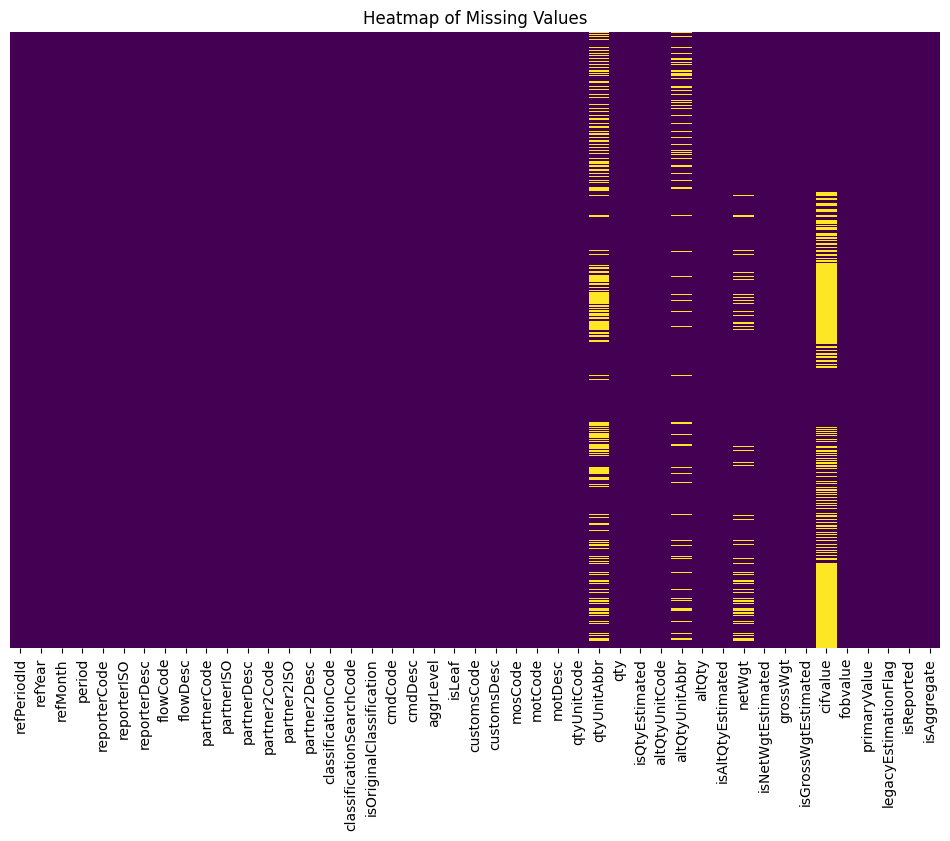

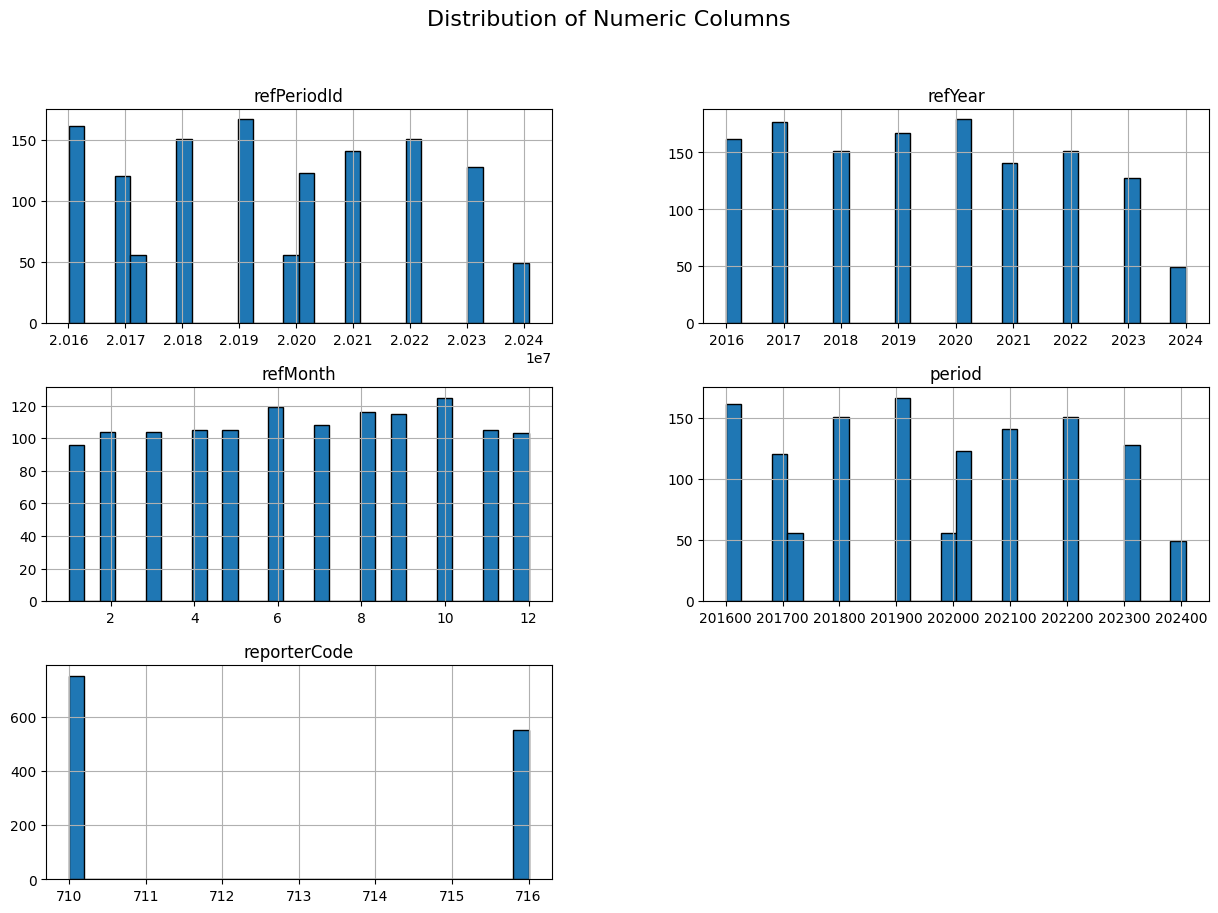

ValueError: could not convert string to float: 'ZAF'

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
eda_df = pd.read_excel('new trail data.xlsx', sheet_name='new file')

# Visualize Missing Values
plt.figure(figsize=(12, 8))
sns.heatmap(eda_df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Heatmap of Missing Values")
plt.show()

# Select numeric columns
numeric_columns = eda_df.select_dtypes(include=['float64', 'int64']).columns[:5]  # Limit to first 5 for clarity

# Plot histograms for numeric columns
eda_df[numeric_columns].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Distribution of Numeric Columns", fontsize=16)
plt.show()

# Correlation Analysis
correlation = eda_df.corr()  # Compute pairwise correlation for numeric features

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import zscore

In [3]:
file_path = 'new trail data.xlsx'
data = pd.read_excel(file_path) # Changed pd.data to pd.read_excel to read the excel file.

In [4]:
import pandas as pd

# Assuming 'df' is your DataFrame
columns_to_keep = [
    "refPeriodId", "reporterCode", "reporterISO", "reporterDesc", "flowDesc",
    "partnerISO", "partnerDesc", "partner2ISO", "partner2Desc", "classificationCode",
    "isOriginalClassification", "cmdCode", "cmdDesc", "aggrLevel", "isLeaf",
    "qtyUnitCode", "qtyUnitAbbr", "qty", "isQtyEstimated", "altQtyUnitCode",
    "altQtyUnitAbbr", "altQty", "isAltQtyEstimated", "netWgt", "isNetWgtEstimated",
    "isGrossWgtEstimated", "fobvalue", "primaryValue", "isReported", "isAggregate"
]

# Keep only the specified columns
data = data[columns_to_keep]

# Display the updated DataFrame
print(data.head())

   refPeriodId  reporterCode reporterISO  reporterDesc flowDesc partnerISO  \
0     20160101           710         ZAF  South Africa   Export        W00   
1     20160101           710         ZAF  South Africa   Export        NAM   
2     20160101           716         ZWE      Zimbabwe   Export        W00   
3     20160101           716         ZWE      Zimbabwe   Export        ZAF   
4     20160101           710         ZAF  South Africa   Export        W00   

    partnerDesc partner2ISO partner2Desc classificationCode  ...  \
0         World         W00        World                 H4  ...   
1       Namibia         W00        World                 H4  ...   
2         World         W00        World                 H4  ...   
3  South Africa         W00        World                 H4  ...   
4         World         W00        World                 H4  ...   

   altQtyUnitAbbr   altQty isAltQtyEstimated   netWgt  isNetWgtEstimated  \
0             NaN     0.00             False  

**a) Dataset Overview:**

In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   refPeriodId               1305 non-null   int64  
 1   reporterCode              1305 non-null   int64  
 2   reporterISO               1305 non-null   object 
 3   reporterDesc              1305 non-null   object 
 4   flowDesc                  1305 non-null   object 
 5   partnerISO                1305 non-null   object 
 6   partnerDesc               1305 non-null   object 
 7   partner2ISO               1305 non-null   object 
 8   partner2Desc              1305 non-null   object 
 9   classificationCode        1305 non-null   object 
 10  isOriginalClassification  1305 non-null   bool   
 11  cmdCode                   1305 non-null   int64  
 12  cmdDesc                   1305 non-null   object 
 13  aggrLevel                 1305 non-null   int64  
 14  isLeaf  

**b) Descriptive Statistics:**

In [7]:
print(data.describe())

        refPeriodId  reporterCode        cmdCode    aggrLevel  qtyUnitCode  \
count  1.305000e+03   1305.000000    1305.000000  1305.000000  1305.000000   
mean   2.019587e+07    712.537931  387809.533333     5.081992     5.289655   
std    2.370573e+04      2.965338  350802.069550     0.997015     4.130400   
min    2.016010e+07    710.000000    7108.000000     4.000000    -1.000000   
25%    2.017110e+07    710.000000    7108.000000     4.000000    -1.000000   
50%    2.019120e+07    710.000000  710811.000000     6.000000     8.000000   
75%    2.022010e+07    716.000000  710813.000000     6.000000     8.000000   
max    2.024080e+07    716.000000  710813.000000     6.000000     8.000000   

                 qty  altQtyUnitCode        altQty         netWgt  \
count    1305.000000     1305.000000  1.305000e+03    1188.000000   
mean     3692.938998        8.219157  2.282432e+05    4204.526385   
std     13576.161278        4.351444  7.628769e+05   14149.051333   
min         0.000000 

***c) Check for missing values***

In [8]:
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
refPeriodId                   0
reporterCode                  0
reporterISO                   0
reporterDesc                  0
flowDesc                      0
partnerISO                    0
partnerDesc                   0
partner2ISO                   0
partner2Desc                  0
classificationCode            0
isOriginalClassification      0
cmdCode                       0
cmdDesc                       0
aggrLevel                     0
isLeaf                        0
qtyUnitCode                   0
qtyUnitAbbr                 393
qty                           0
isQtyEstimated                0
altQtyUnitCode                0
altQtyUnitAbbr              158
altQty                        0
isAltQtyEstimated             0
netWgt                      117
isNetWgtEstimated             0
isGrossWgtEstimated           0
fobvalue                      0
primaryValue                  0
isReported                    0
isAggregate                   0
dtype: int64


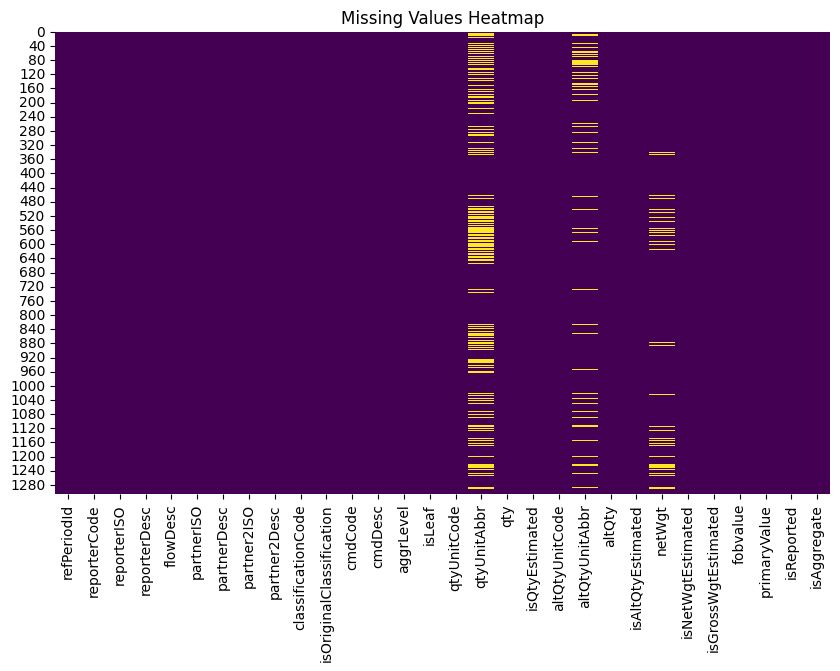

In [9]:
# Visualize missing values as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

**d) Percentage of missing values**

In [10]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
print("Missing Values Percentage:\n", missing_percentage)

Missing Values Percentage:
 refPeriodId                  0.000000
reporterCode                 0.000000
reporterISO                  0.000000
reporterDesc                 0.000000
flowDesc                     0.000000
partnerISO                   0.000000
partnerDesc                  0.000000
partner2ISO                  0.000000
partner2Desc                 0.000000
classificationCode           0.000000
isOriginalClassification     0.000000
cmdCode                      0.000000
cmdDesc                      0.000000
aggrLevel                    0.000000
isLeaf                       0.000000
qtyUnitCode                  0.000000
qtyUnitAbbr                 30.114943
qty                          0.000000
isQtyEstimated               0.000000
altQtyUnitCode               0.000000
altQtyUnitAbbr              12.107280
altQty                       0.000000
isAltQtyEstimated            0.000000
netWgt                       8.965517
isNetWgtEstimated            0.000000
isGrossWgtEstimated   

 **e) Remove Missing**

In [15]:
# Remove rows where the specified columns have missing values
df_cleaned = data.dropna(subset=['qtyUnitAbbr', 'altQtyUnitAbbr', 'netWgt'])

# Drop the columns 'Value_Z' and 'Weight_Z'
df_cleaned = df_cleaned.drop(columns=['Value_Z', 'Weight_Z'], errors='ignore')  # Changed data_cleaned to df_cleaned, added errors='ignore'

# Display the cleaned DataFrame information
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 875 entries, 2 to 1304
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   refPeriodId               875 non-null    int64  
 1   reporterCode              875 non-null    int64  
 2   reporterISO               875 non-null    object 
 3   reporterDesc              875 non-null    object 
 4   flowDesc                  875 non-null    object 
 5   partnerISO                875 non-null    object 
 6   partnerDesc               875 non-null    object 
 7   partner2ISO               875 non-null    object 
 8   partner2Desc              875 non-null    object 
 9   classificationCode        875 non-null    object 
 10  isOriginalClassification  875 non-null    bool   
 11  cmdCode                   875 non-null    int64  
 12  cmdDesc                   875 non-null    object 
 13  aggrLevel                 875 non-null    int64  
 14  isLeaf        

In [16]:
print(df_cleaned.head())  # Prints the first 5 rows of the DataFrame


    refPeriodId  reporterCode reporterISO  reporterDesc flowDesc partnerISO  \
2      20160101           716         ZWE      Zimbabwe   Export        W00   
3      20160101           716         ZWE      Zimbabwe   Export        ZAF   
6      20160101           716         ZWE      Zimbabwe   Export        W00   
7      20160101           716         ZWE      Zimbabwe   Export        ZAF   
11     20160201           710         ZAF  South Africa   Export        _X    

     partnerDesc partner2ISO partner2Desc classificationCode  ...  \
2          World         W00        World                 H4  ...   
3   South Africa         W00        World                 H4  ...   
6          World         W00        World                 H4  ...   
7   South Africa         W00        World                 H4  ...   
11    Areas, nes         W00        World                 H4  ...   

    altQtyUnitAbbr    altQty isAltQtyEstimated    netWgt  isNetWgtEstimated  \
2               kg   1412.26   

**f) Outlier Detection**

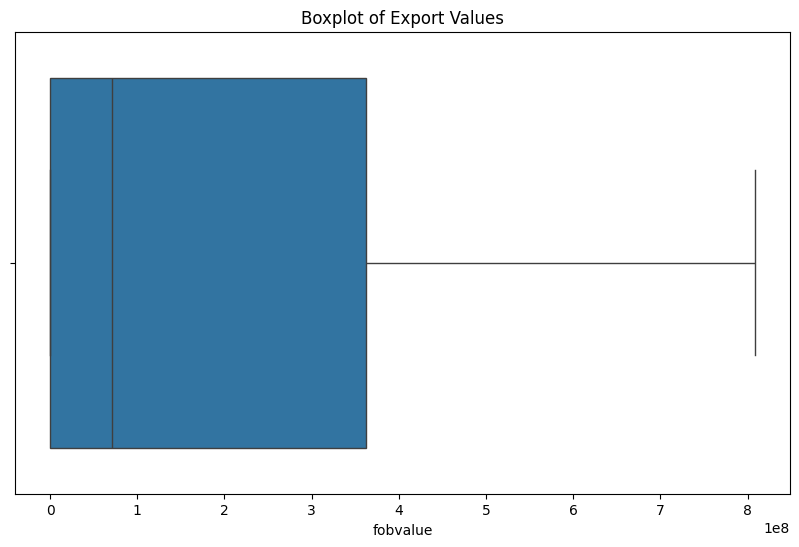

In [17]:
# Boxplot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['fobvalue'])
plt.title('Boxplot of Export Values')
plt.show()



# **2. Product Analysis:**


**Countries by Export Value and Volume:**

In [18]:
# Filter the data for gold exports from South Africa and Zimbabwe
gold_exports = df_cleaned[
    (df_cleaned['cmdDesc'].str.contains("Gold", case=False, na=False)) &  # Filter for gold
    (df_cleaned['reporterDesc'].isin(['South Africa', 'Zimbabwe']))  # Filter for South Africa and Zimbabwe
]

# Group by partner country and aggregate values
top_gold_countries = gold_exports.groupby('partnerDesc').agg({
    'fobvalue': 'sum',  # Use 'fobvalue' to sum export values
    'netWgt': 'sum'     # Use 'netWgt' to sum export volumes
}).reset_index()

# Rename columns for clarity
top_gold_countries.rename(columns={'fobvalue': 'Total Export Value', 'netWgt': 'Total Export Volume'}, inplace=True)

# Sort by export value to identify the top countries by export value
top_gold_countries = top_gold_countries.sort_values(by='Total Export Value', ascending=False).head(10)

# Display the top countries by export value and volume
print("Top Countries for Gold Exported by South Africa and Zimbabwe:")
print(top_gold_countries)


Top Countries for Gold Exported by South Africa and Zimbabwe:
             partnerDesc  Total Export Value  Total Export Volume
0             Areas, nes        9.805884e+10           2439569.62
10                 World        7.848871e+10           2010055.06
9   United Arab Emirates        1.277014e+10            234413.06
5           South Africa        4.106121e+09            101116.00
7                 Uganda        2.626976e+08              4406.74
2   China, Hong Kong SAR        3.596468e+07               711.96
6     Special Categories        2.541060e+07               471.46
8                Ukraine        2.030201e+07               332.80
3             Mozambique        4.762845e+06                75.10
4                Namibia        3.035147e+06               723.08


In [19]:
# Group by Product and calculate total export value and volume
top_vol = df_cleaned.groupby('cmdCode').agg({
    'fobvalue': 'sum',
    'netWgt': 'sum'
}).reset_index()

# Rename columns for clarity if needed
top_vol.rename(columns={'fobvalue': 'Total Export Value', 'netWgt': 'Total Export Volume'}, inplace=True)

# Sort by export volume to get the top 10 products
top_volume_products = top_vol.sort_values(by='Total Export Volume', ascending=False).head(10)

# Filter the original dataset for the top 10 product codes
top_product_codes = top_volume_products['cmdCode']
filtered_data = df_cleaned[df_cleaned['cmdCode'].isin(top_product_codes)]

# Group by reporter and partner country for the top products
countries_by_product = filtered_data.groupby(['reporterDesc', 'partnerDesc']).agg({
    'fobvalue': 'sum',
    'netWgt': 'sum'
}).reset_index()

# Rename columns for clarity
countries_by_product.rename(columns={
    'fobvalue': 'Total Export Value',
    'netWgt': 'Total Export Volume'
}, inplace=True)

# Sort by export value and volume for a clean view
countries_by_product = countries_by_product.sort_values(by='Total Export Value', ascending=False)

# Display the results
print("\nCountries by Export Value and Volume for Top 10 Products by Volume:")
print(countries_by_product)



Countries by Export Value and Volume for Top 10 Products by Volume:
    reporterDesc           partnerDesc  Total Export Value  \
0   South Africa            Areas, nes        9.805884e+10   
3   South Africa                 World        6.418929e+10   
11      Zimbabwe                 World        1.429941e+10   
10      Zimbabwe  United Arab Emirates        1.277014e+10   
6       Zimbabwe          South Africa        4.106121e+09   
8       Zimbabwe                Uganda        2.626976e+08   
4       Zimbabwe  China, Hong Kong SAR        3.596468e+07   
7       Zimbabwe    Special Categories        2.541060e+07   
9       Zimbabwe               Ukraine        2.030201e+07   
5       Zimbabwe            Mozambique        4.762845e+06   
2   South Africa               Namibia        3.035147e+06   
1   South Africa              Botswana        5.009850e+04   

    Total Export Volume  
0            2439569.62  
3            1720863.76  
11            289191.30  
10            234413

**Commodities by Export Volume:**

In [20]:
# Group by Product and calculate total export value and volume
top_vol = df_cleaned.groupby('cmdCode').agg({
    'fobvalue': 'sum',
    'netWgt': 'sum'
}).reset_index()

# Rename columns for clarity if needed
top_vol.rename(columns={'fobvalue': 'Total Export Value', 'netWgt': 'Total Export Volume'}, inplace=True)

# Sort by export value and export volume
top_volume = top_vol.sort_values(by='Total Export Volume', ascending=False).head(10)

# Display top 10 products by volume
print("\nCommodities by Export Volume:")
print(top_volume)



Commodities by Export Volume:
   cmdCode  Total Export Value  Total Export Volume
3   710813        1.050295e+11           2578328.72
0     7108        8.874611e+10           2213441.34
1   710811        2.269636e+05                92.04
2   710812        1.415691e+05                23.10


 **Visualize the Countries by Export Value**

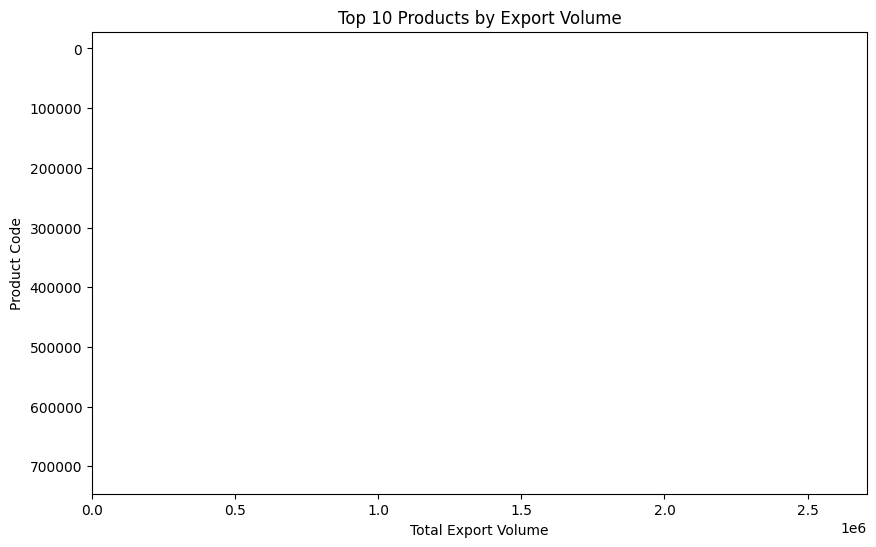

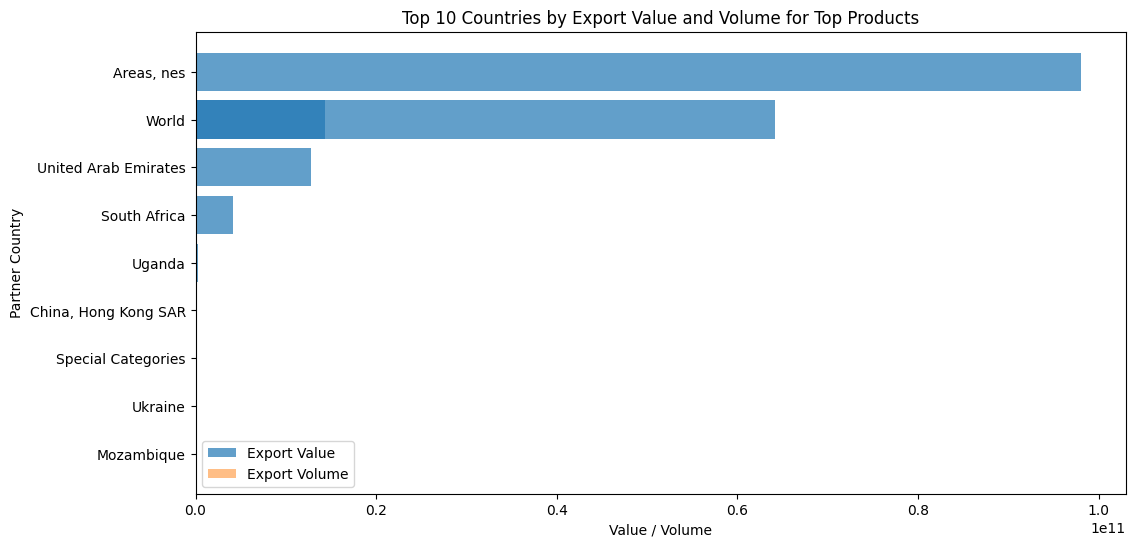

In [21]:

# Visualization for Top 10 Products by Export Volume
plt.figure(figsize=(10, 6))
plt.barh(top_volume_products['cmdCode'], top_volume_products['Total Export Volume'])
plt.xlabel('Total Export Volume')
plt.ylabel('Product Code')
plt.title('Top 10 Products by Export Volume')
plt.gca().invert_yaxis()  # To display the highest volume product at the top
plt.show()

# Visualization for Countries by Export Value and Volume for Top Products
top_countries_chart = countries_by_product.sort_values(by='Total Export Value', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_countries_chart['partnerDesc'], top_countries_chart['Total Export Value'], label='Export Value', alpha=0.7)
plt.barh(top_countries_chart['partnerDesc'], top_countries_chart['Total Export Volume'], label='Export Volume', alpha=0.5)
plt.xlabel('Value / Volume')
plt.ylabel('Partner Country')
plt.title('Top 10 Countries by Export Value and Volume for Top Products')
plt.legend()
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.show()


**Visualization for top products by volume**

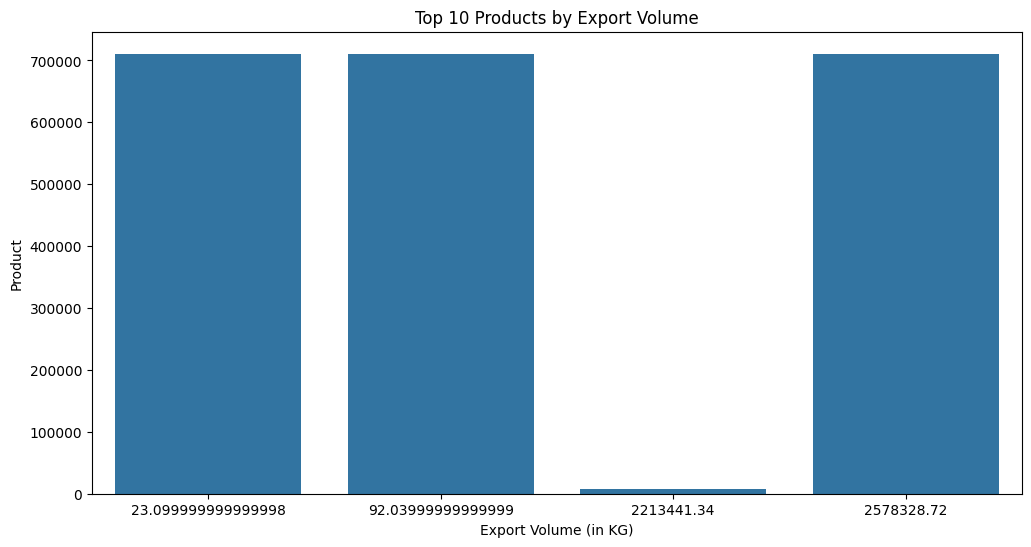

In [23]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_volume, x='Total Export Volume', y='cmdCode') # Changed 'Quantity in KG' to 'Total Export Volume', and top_products_by_volume to top_volume
plt.title('Top 10 Products by Export Volume')
plt.xlabel('Export Volume (in KG)')
plt.ylabel('Product')
plt.show()

**b) Analyze Export Trends for Gold Over Time**

In [30]:
# Analyze trends for a specific product (e.g., top product)
#top_product_name = top_products_by_value.iloc['cmdDesc'] #This line is using the undefined variable 'top_products_by_value'
top_product_name = top_products_value.index[0]  # Access the index (product name) from the top_products_value Series - This was already commented out. Uncommented it and removed the problematic line.
product_trend = df[df['cmdDesc'] == top_product_name]

# Group by Month for time-series analysis
product_trend_by_month = product_trend.groupby('date')['fobvalue'].sum() # Access values by 'date' and 'fobvalue'

# Plot the trend
plt.figure(figsize=(12, 6))
product_trend_by_month.plot(marker='o')
plt.title(f'Export Trends for {top_product_name}')
plt.xlabel('Date') # Updated label to 'Date'
plt.ylabel('Export Value')
plt.grid()
plt.show()

# For multiple products (optional)
top_5_products = top_products_value.index[:5]  # Access the top 5 product names from the index
plt.figure(figsize=(12, 6))
for product in top_5_products:
    product_data = df[df['cmdDesc'] == product]
    product_trend = product_data.groupby('date')['fobvalue'].sum() # Group by 'date' and sum 'fobvalue'
    product_trend.plot(label=product)

plt.title('Export Trends for Top 5 Products')
plt.xlabel('Date') # Updated label to 'Date'
plt.ylabel('Export Value')
plt.legend()
plt.grid()
plt.show()

NameError: name 'top_products_value' is not defined

# **2. Product Analysis:**

Top 10 Products by Export Value:
cmdDesc
Gold (including gold plated with platinum) unwrought or in semi-manufactured forms, or in powder form    1.195440e+11
Metals; gold, semi-manufactured                                                                          1.195410e+11
Metals; gold, non-monetary, unwrought (but not powder)                                                   2.711813e+06
Metals; gold, non-monetary, powder                                                                       2.791094e+05
Name: fobvalue, dtype: float64

Top 10 Products by Export Volume:
cmdDesc
Metals; gold, semi-manufactured                                                                          2570396.017
Gold (including gold plated with platinum) unwrought or in semi-manufactured forms, or in powder form    2248707.218
Metals; gold, non-monetary, powder                                                                            92.040
Metals; gold, non-monetary, unwrought (but not powder)        

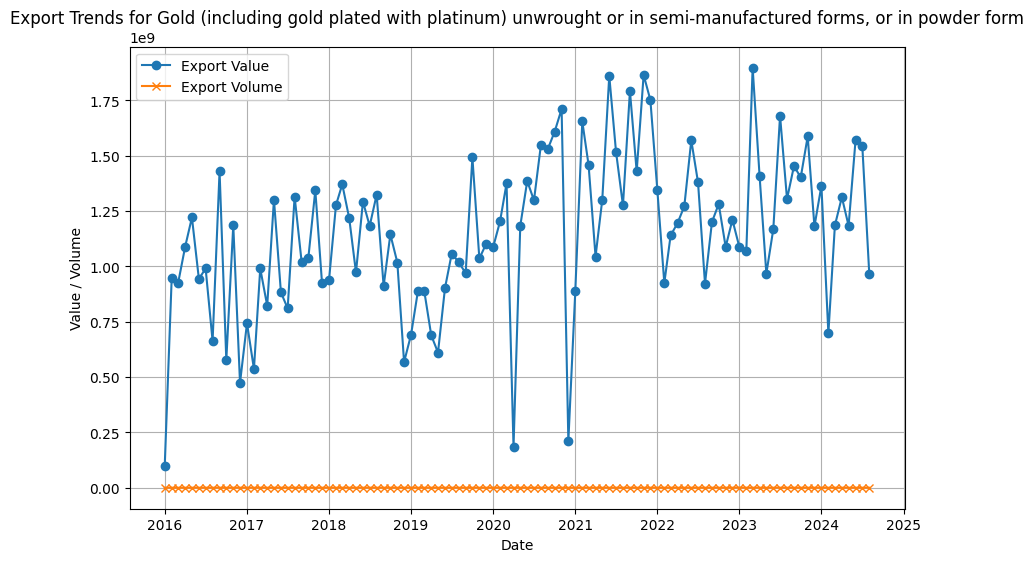


Number of Products Contributing Significantly (>=1%):
2


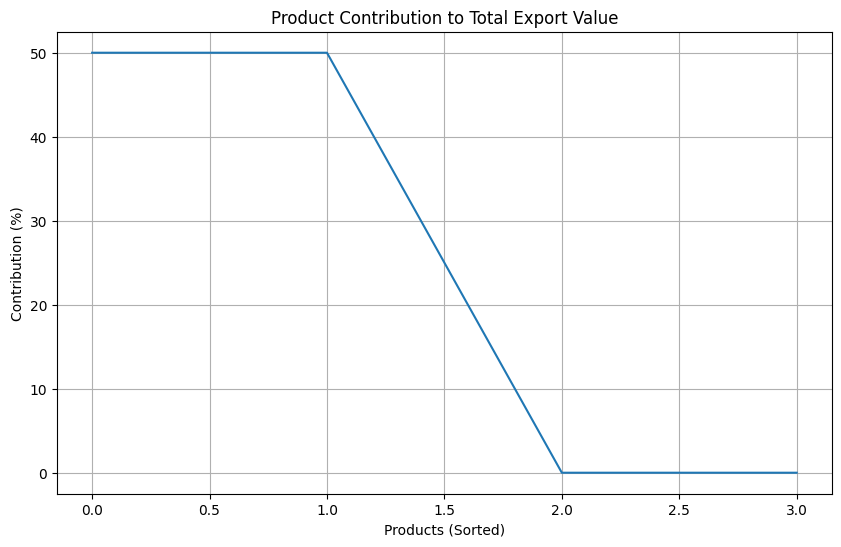


Top 5 Countries with Product Breakdown:
cmdDesc               Gold (including gold plated with platinum) unwrought or in semi-manufactured forms, or in powder form  \
partnerDesc                                                                                                                   
Areas, nes                                                 4.930462e+10                                                       
Belgium                                                    8.717843e+05                                                       
Botswana                                                   2.644627e+04                                                       
China                                                      5.055100e+01                                                       
China, Hong Kong SAR                                       2.543352e+07                                                       

cmdDesc               Metals; gold, non-monetary, powder  \
partnerDe

<ipython-input-32-79f87bf34b58>:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_export_value = df.groupby('cmdDesc').apply(lambda x: x['fobvalue'].sum() / x['qty'].sum())
<ipython-input-32-79f87bf34b58>:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weight_to_value_ratio = df.groupby('cmdDesc').apply(lambda x: x['netWgt'].sum() / x['fobvalue'].sum())


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# Convert refYear and refMonth to a datetime column for trend analysis
df['date'] = pd.to_datetime(df['refYear'].astype(str) + '-' + df['refMonth'].astype(str), format='%Y-%m')

# 1. Top Products
## By Export Value
top_products_value = df.groupby('cmdDesc')['fobvalue'].sum().sort_values(ascending=False).head(10)

## By Export Volume
top_products_volume = df.groupby('cmdDesc')['qty'].sum().sort_values(ascending=False).head(10)

print("Top 10 Products by Export Value:")
print(top_products_value)
print("\nTop 10 Products by Export Volume:")
print(top_products_volume)

# 2. Trends
## Export Trends by Product
def plot_product_trends(product_name):
    product_data = df[df['cmdDesc'] == product_name]
    trends = product_data.groupby('date')[['fobvalue', 'qty']].sum()
    plt.figure(figsize=(10, 6))
    plt.plot(trends.index, trends['fobvalue'], label='Export Value', marker='o')
    plt.plot(trends.index, trends['qty'], label='Export Volume', marker='x')
    plt.title(f'Export Trends for {product_name}')
    plt.xlabel('Date')
    plt.ylabel('Value / Volume')
    plt.legend()
    plt.grid()
    plt.show()

# Example: Plot trends for the top product by export value
plot_product_trends(top_products_value.index[0])

# 3. Diversification
## Contribution Analysis
product_contribution = df.groupby('cmdDesc')['fobvalue'].sum()
product_contribution_percent = (product_contribution / product_contribution.sum()) * 100
significant_products = product_contribution_percent[product_contribution_percent >= 1]

print("\nNumber of Products Contributing Significantly (>=1%):")
print(len(significant_products))

## Long-Tail Analysis
plt.figure(figsize=(10, 6))
plt.plot(product_contribution_percent.sort_values(ascending=False).values)
plt.title('Product Contribution to Total Export Value')
plt.xlabel('Products (Sorted)')
plt.ylabel('Contribution (%)')
plt.grid()
plt.show()

# 4. Product Categorization
## By Partner Country
products_by_country = df.groupby(['partnerDesc', 'cmdDesc'])['fobvalue'].sum().unstack().fillna(0)

print("\nTop 5 Countries with Product Breakdown:")
print(products_by_country.head(5))

# 5. Performance Indicators
## Average Export Value Per Product
average_export_value = df.groupby('cmdDesc').apply(lambda x: x['fobvalue'].sum() / x['qty'].sum())

print("\nAverage Export Value Per Product:")
print(average_export_value.head(10))

## Weight-to-Value Ratio
weight_to_value_ratio = df.groupby('cmdDesc').apply(lambda x: x['netWgt'].sum() / x['fobvalue'].sum())

print("\nWeight-to-Value Ratio Per Product:")
print(weight_to_value_ratio.head(10))

# 6. High-Volume and High-Value Products
combined_analysis = df.groupby('cmdDesc').agg({
    'fobvalue': 'sum',
    'qty': 'sum'
}).sort_values(by='fobvalue', ascending=False)

print("\nHigh-Volume and High-Value Products:")
print(combined_analysis.head(10))

# 7. Geographic Distribution
## Product by Region
region_distribution = df.groupby(['partnerDesc', 'cmdDesc'])['fobvalue'].sum().unstack().fillna(0)
print("\nRegion Distribution for Top Products:")
print(region_distribution.head(5))


# **3. Country and Partner Analysis:**

Top 10 Export Destinations by Value:
 partnerDesc
World                   1.195440e+11
Areas, nes              9.860924e+10
United Arab Emirates    1.545933e+10
South Africa            5.046148e+09
Uganda                  2.626976e+08
Mozambique              6.449910e+07
China, Hong Kong SAR    5.086703e+07
Special Categories      2.572970e+07
Ukraine                 2.030201e+07
Namibia                 3.353765e+06
Name: fobvalue, dtype: float64
Top 10 Export Destinations by Quantity:
 partnerDesc
Areas, nes              2439569.620
World                   2047600.641
United Arab Emirates     221083.708
South Africa             103950.368
Uganda                     4406.970
Namibia                     728.202
China, Hong Kong SAR        711.992
Special Categories          481.394
Mozambique                  362.900
Ukraine                     332.800
Name: qty, dtype: float64

Major Partners Contributing >= 5%:
 partnerDesc
Areas, nes              41.243920
United Arab Emirates     6.

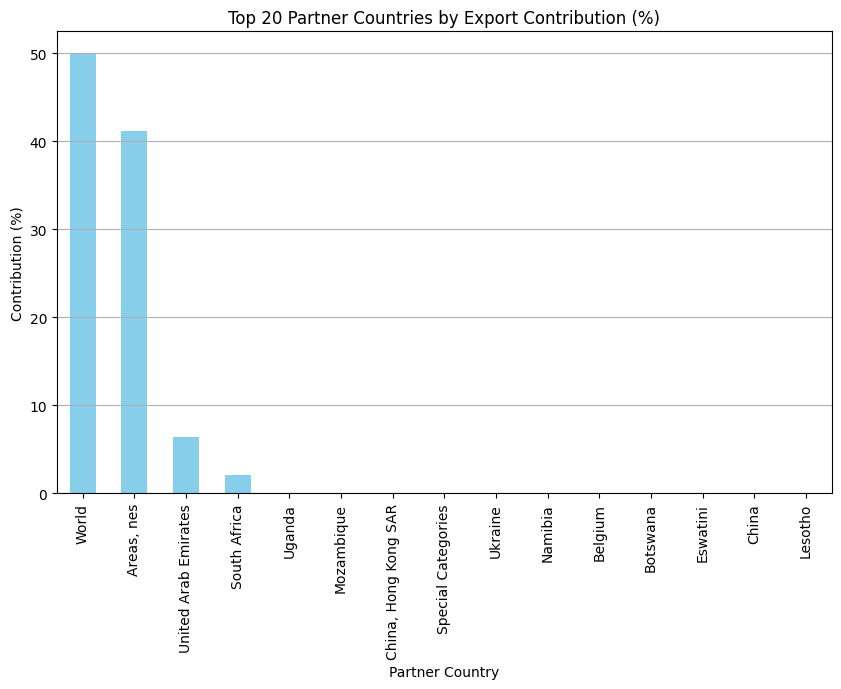


Export Distribution by Region:
 Region
Africa    5.046148e+09
Asia      1.011020e+02
Other     2.340418e+11
Name: fobvalue, dtype: float64


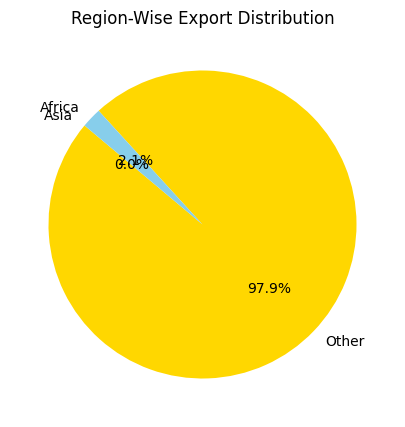

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# Ensure `refYear` and `refMonth` are integers for time-based analysis
df['date'] = pd.to_datetime(df['refYear'].astype(str) + '-' + df['refMonth'].astype(str), format='%Y-%m')

# 1. Top Export Destinations
## By Total Export Value
top_countries_value = df.groupby('partnerDesc')['fobvalue'].sum().sort_values(ascending=False).head(10)
print("Top 10 Export Destinations by Value:\n", top_countries_value)

## By Total Export Quantity
top_countries_quantity = df.groupby('partnerDesc')['qty'].sum().sort_values(ascending=False).head(10)
print("Top 10 Export Destinations by Quantity:\n", top_countries_quantity)

# 2. Partner Concentration
## Contribution of Each Partner to Total Export Value
partner_contribution = df.groupby('partnerDesc')['fobvalue'].sum()
partner_percentage = (partner_contribution / partner_contribution.sum()) * 100

## Identify Major Partners (e.g., those contributing >= 5% of total exports)
major_partners = partner_percentage[partner_percentage >= 5]
print("\nMajor Partners Contributing >= 5%:\n", major_partners)

# Plot Partner Contribution
plt.figure(figsize=(10, 6))
partner_percentage.sort_values(ascending=False).head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Partner Countries by Export Contribution (%)')
plt.ylabel('Contribution (%)')
plt.xlabel('Partner Country')
plt.grid(axis='y')
plt.show()

# 3. Region-Wise Distribution
## Assuming Regions Are Categorized Separately (e.g., Africa, Europe, etc.)
def map_regions(country):
    region_mapping = {
        'Africa': ['South Africa', 'Nigeria', 'Kenya', 'Ghana'],
        'Europe': ['Germany', 'France', 'UK', 'Italy'],
        'Asia': ['China', 'India', 'Japan', 'South Korea'],
        'North America': ['USA', 'Canada', 'Mexico'],
        'South America': ['Brazil', 'Argentina', 'Chile']
    }
    for region, countries in region_mapping.items():
        if country in countries:
            return region
    return 'Other'

# Apply Region Mapping
df['Region'] = df['partnerDesc'].apply(map_regions)

# Group by Region and Calculate Export Value
region_distribution = df.groupby('Region')['fobvalue'].sum()
print("\nExport Distribution by Region:\n", region_distribution)

# Plot Region-Wise Distribution
plt.figure(figsize=(8, 5))
region_distribution.sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['gold', 'skyblue', 'lightgreen', 'orange', 'pink'])
plt.title('Region-Wise Export Distribution')
plt.ylabel('')
plt.show()


# **4. Time-Series Analysis:**

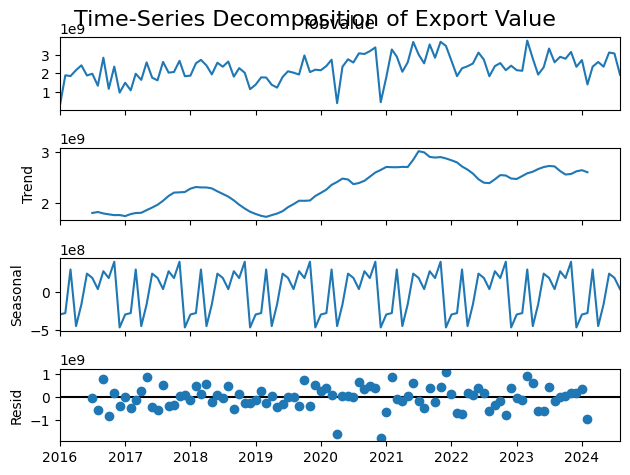

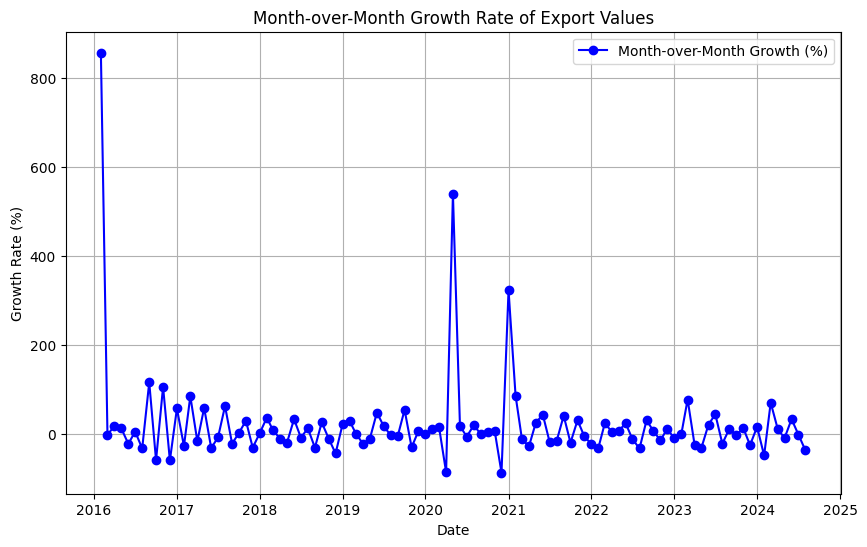

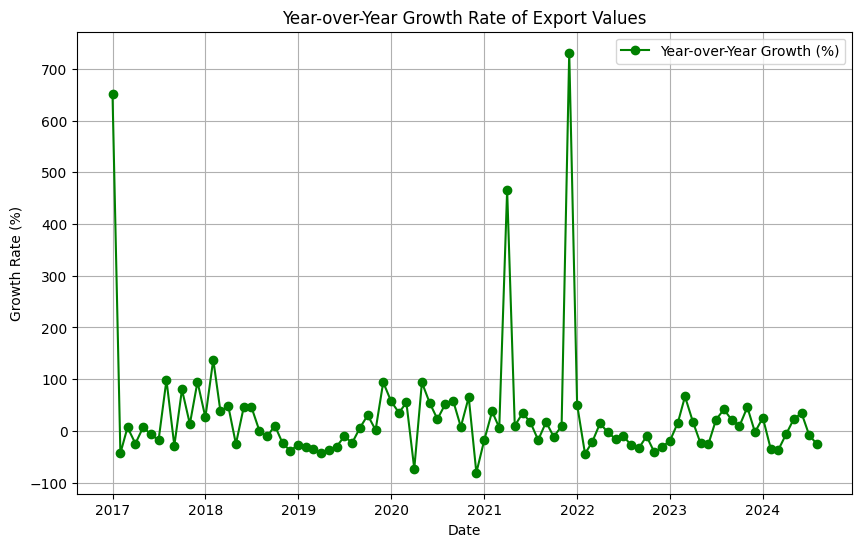

Month-over-Month Growth Rates:
 date
2024-04-01    10.778030
2024-05-01    -9.834750
2024-06-01    32.760690
2024-07-01    -1.712637
2024-08-01   -37.455373
Name: fobvalue, dtype: float64

Year-over-Year Growth Rates:
 date
2024-04-01    -6.714015
2024-05-01    22.348720
2024-06-01    34.492671
2024-07-01    -8.105154
2024-08-01   -25.946393
Name: fobvalue, dtype: float64


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# Ensure `refYear` and `refMonth` are integers for time-based analysis
df['date'] = pd.to_datetime(df['refYear'].astype(str) + '-' + df['refMonth'].astype(str), format='%Y-%m')

# Group by Date to Aggregate Export Values Over Time
time_series = df.groupby('date')['fobvalue'].sum().sort_index()

# 1. Time-Series Decomposition
## Decompose the export value data into trend, seasonality, and residuals
result = seasonal_decompose(time_series, model='additive', period=12)

# Plot Decomposition Results
result.plot()
plt.suptitle('Time-Series Decomposition of Export Value', fontsize=16)
plt.show()

# 2. Growth Rates
## Calculate Month-over-Month Growth Rates
time_series_mom_growth = time_series.pct_change() * 100

## Calculate Year-over-Year Growth Rates
time_series_yoy_growth = time_series.pct_change(12) * 100

# Plot Growth Rates
plt.figure(figsize=(10, 6))
plt.plot(time_series_mom_growth, label='Month-over-Month Growth (%)', marker='o', linestyle='-', color='blue')
plt.title('Month-over-Month Growth Rate of Export Values')
plt.ylabel('Growth Rate (%)')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_series_yoy_growth, label='Year-over-Year Growth (%)', marker='o', linestyle='-', color='green')
plt.title('Year-over-Year Growth Rate of Export Values')
plt.ylabel('Growth Rate (%)')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.show()

# Display Growth Rates for Validation
print("Month-over-Month Growth Rates:\n", time_series_mom_growth.tail())
print("\nYear-over-Year Growth Rates:\n", time_series_yoy_growth.tail())


 Forecasting:
#** Predict future export values using: **


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


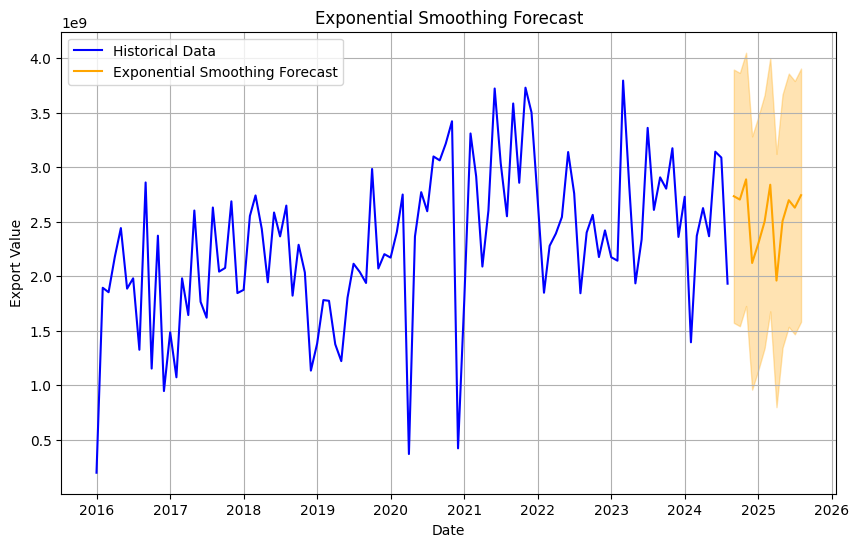

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


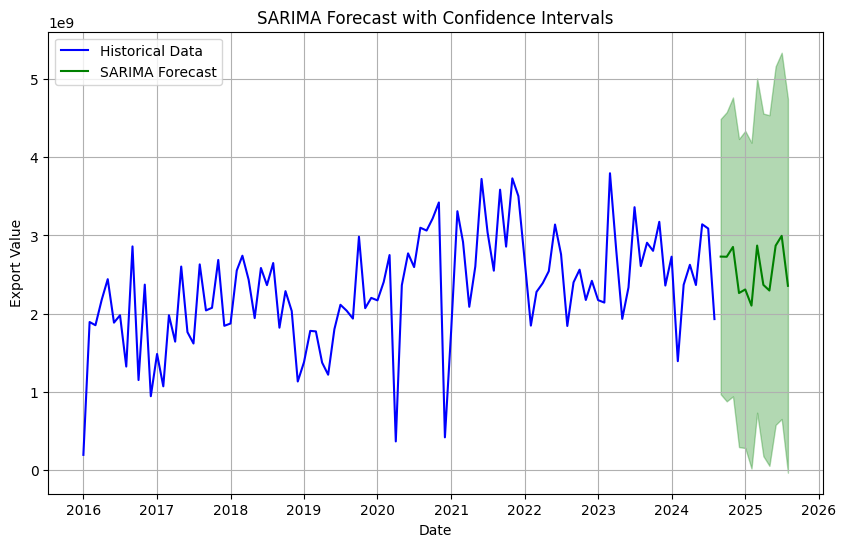

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9xvp2a21/io9t0uvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9xvp2a21/65qtc__u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=153', 'data', 'file=/tmp/tmp9xvp2a21/io9t0uvv.json', 'init=/tmp/tmp9xvp2a21/65qtc__u.json', 'output', 'file=/tmp/tmp9xvp2a21/prophet_model50dl87ym/prophet_model-20250117010022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:00:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:00:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/pr

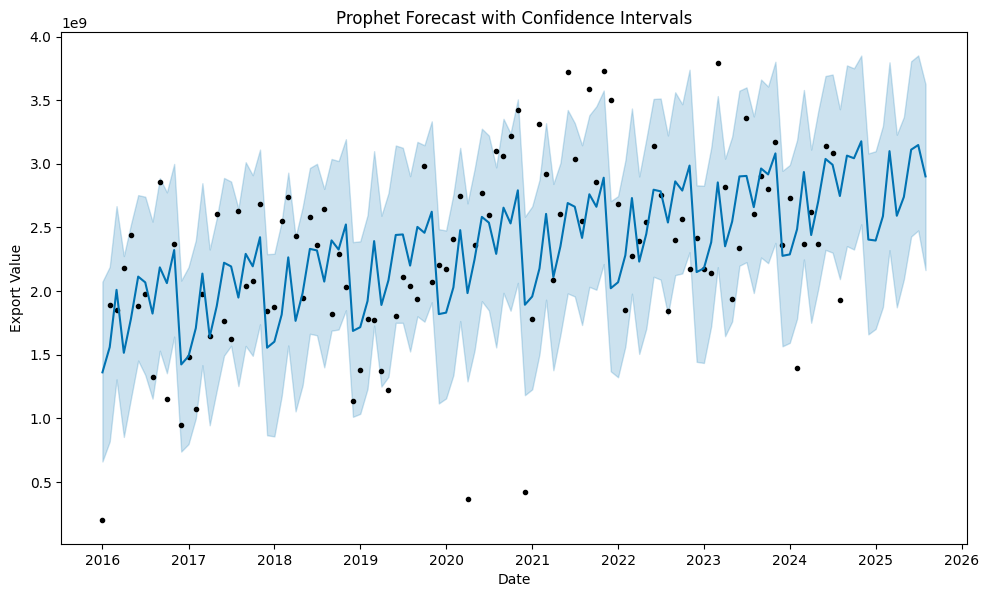

Exponential Smoothing Forecast:
 2024-09-01    2.733924e+09
2024-10-01    2.703210e+09
2024-11-01    2.888602e+09
2024-12-01    2.121270e+09
2025-01-01    2.301605e+09
2025-02-01    2.501571e+09
2025-03-01    2.839302e+09
2025-04-01    1.960321e+09
2025-05-01    2.505209e+09
2025-06-01    2.697448e+09
2025-07-01    2.628977e+09
2025-08-01    2.743341e+09
Freq: MS, dtype: float64

SARIMA Forecast:
 2024-09-01    2.729911e+09
2024-10-01    2.727866e+09
2024-11-01    2.853159e+09
2024-12-01    2.264504e+09
2025-01-01    2.310007e+09
2025-02-01    2.103838e+09
2025-03-01    2.870587e+09
2025-04-01    2.368749e+09
2025-05-01    2.296580e+09
2025-06-01    2.869707e+09
2025-07-01    2.994809e+09
2025-08-01    2.356693e+09
Freq: MS, Name: predicted_mean, dtype: float64

Prophet Forecast:
             ds          yhat    yhat_lower    yhat_upper
104 2024-08-31  3.064217e+09  2.353117e+09  3.772797e+09
105 2024-09-30  3.043583e+09  2.326548e+09  3.750195e+09
106 2024-10-31  3.176936e+09  2.52468

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet


# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# Ensure `refYear` and `refMonth` are integers for time-based analysis
df['date'] = pd.to_datetime(df['refYear'].astype(str) + '-' + df['refMonth'].astype(str), format='%Y-%m')

# Group by Date to Aggregate Export Values Over Time
time_series = df.groupby('date')['fobvalue'].sum().sort_index()

# 1. Forecasting with Exponential Smoothing
exp_model = ExponentialSmoothing(time_series, seasonal='add', seasonal_periods=12).fit()
exp_forecast = exp_model.forecast(12)

# Plot Exponential Smoothing Forecast
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Historical Data', color='blue')
plt.plot(exp_forecast, label='Exponential Smoothing Forecast', color='orange')
plt.fill_between(exp_forecast.index, exp_forecast - 1.96 * exp_model.resid.std(),
                 exp_forecast + 1.96 * exp_model.resid.std(), color='orange', alpha=0.3)
plt.title('Exponential Smoothing Forecast')
plt.ylabel('Export Value')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

# 2. Forecasting with SARIMA
sarima_model = SARIMAX(time_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
sarima_forecast = sarima_model.get_forecast(steps=12)
sarima_ci = sarima_forecast.conf_int()

# Plot SARIMA Forecast
plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Historical Data', color='blue')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='green')
plt.fill_between(sarima_forecast.predicted_mean.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1],
                 color='green', alpha=0.3)
plt.title('SARIMA Forecast with Confidence Intervals')
plt.ylabel('Export Value')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.show()

# 3. Forecasting with Prophet
prophet_df = time_series.reset_index().rename(columns={'date': 'ds', 'fobvalue': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=12, freq='M')
prophet_forecast = prophet_model.predict(future)

# Plot Prophet Forecast
fig = prophet_model.plot(prophet_forecast)
plt.title('Prophet Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Export Value')
plt.grid()
plt.show()

# Display Forecast Data for Validation
print("Exponential Smoothing Forecast:\n", exp_forecast)
print("\nSARIMA Forecast:\n", sarima_forecast.predicted_mean)
print("\nProphet Forecast:\n", prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))


# **6. Geographic Analysis:**


In [51]:
!pip install geopandas
!pip install geodatasets
import geopandas as gpd
import matplotlib.pyplot as plt

<Figure size 1500x1000 with 0 Axes>

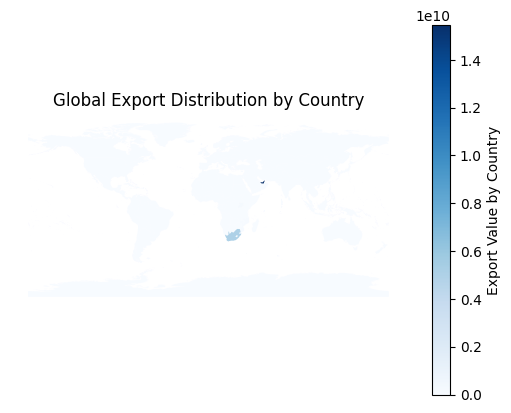

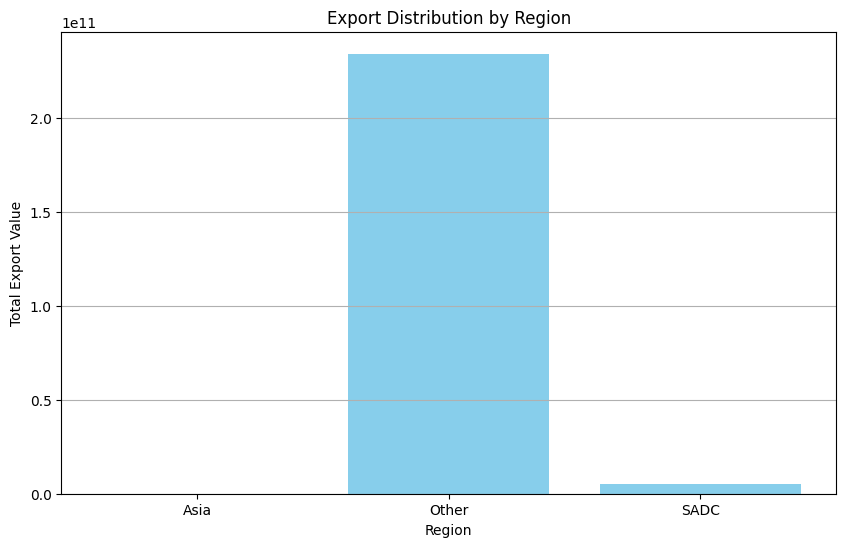

Regional Export Values:
   Region   ExportValue
1  Other  2.339739e+11
2   SADC  5.114053e+09
0   Asia  1.011020e+02


In [54]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geodatasets import get_path

# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# Group exports by country
country_exports = df.groupby('partnerDesc')['fobvalue'].sum().reset_index()
country_exports.columns = ['Country', 'ExportValue']

# Load a publicly available GeoJSON file for world countries
world = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")

# Merge export data with world geometries
world_exports = world.merge(country_exports, how='left', left_on='ADMIN', right_on='Country')

# Fill NaN values in ExportValue with 0 for visualization purposes
world_exports['ExportValue'] = world_exports['ExportValue'].fillna(0)

# 1. Export Mapping
plt.figure(figsize=(15, 10))
world_exports.plot(column='ExportValue', cmap='Blues', legend=True,
                   legend_kwds={'label': "Export Value by Country"})
plt.title('Global Export Distribution by Country')
plt.axis('off')
plt.show()


# 2. Regional Insights
# Define regions manually
def map_region(country):
    sadc = ['South Africa', 'Zimbabwe', 'Namibia', 'Botswana', 'Mozambique']
    eu = ['Germany', 'France', 'United Kingdom', 'Italy', 'Spain']
    asia = ['China', 'India', 'Japan', 'South Korea']

    if country in sadc:
        return 'SADC'
    elif country in eu:
        return 'EU'
    elif country in asia:
        return 'Asia'
    else:
        return 'Other'

# Apply the region mapping
df['Region'] = df['partnerDesc'].apply(map_region)

# Calculate regional exports
regional_exports = df.groupby('Region')['fobvalue'].sum().reset_index()
regional_exports.columns = ['Region', 'ExportValue']

# Plot regional exports
plt.figure(figsize=(10, 6))
plt.bar(regional_exports['Region'], regional_exports['ExportValue'], color='skyblue')
plt.title('Export Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Total Export Value')
plt.grid(axis='y')
plt.show()

# Display top regions by export value
print("Regional Export Values:\n", regional_exports.sort_values(by='ExportValue', ascending=False))

# **7. Price Elasticity Analysis:**


Price Elasticity by Product:
 cmdCode
7108     -384192.821517
710811       -78.328258
710812     -4670.241365
710813   -367148.894709
Name: elasticity, dtype: float64


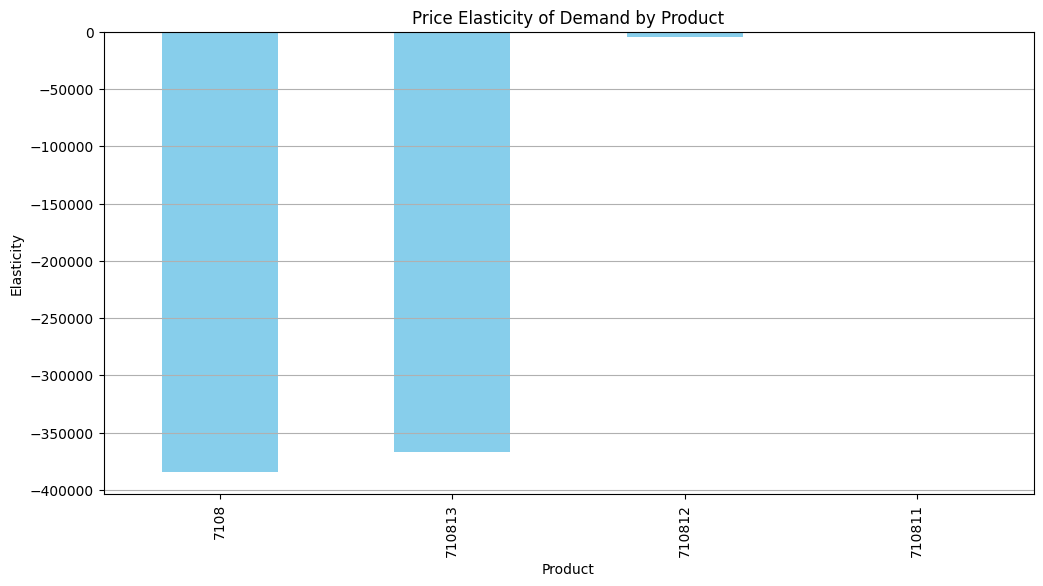


Elasticity Category Summary:
 elasticity_category
Elastic      4
Inelastic    4
Unknown      4
Name: cmdCode, dtype: int64


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# 1. Calculate Export Price
## Ensure no division by zero
df['price'] = df['fobvalue'] / df['qty']
df = df[df['qty'] > 0]  # Filter out rows with zero or negative quantity

# 2. Sort Data for Time-Based Analysis
df = df.sort_values(['cmdCode', 'refYear', 'refMonth'])

# 3. Calculate Percentage Changes
## Group by Product
df['pct_change_price'] = df.groupby('cmdCode')['price'].pct_change() * 100
df['pct_change_qty'] = df.groupby('cmdCode')['qty'].pct_change() * 100

# 4. Calculate Elasticity
## Avoid division by zero
df['elasticity'] = np.where(df['pct_change_price'] != 0,
                            df['pct_change_qty'] / df['pct_change_price'],
                            np.nan)

# 5. Aggregate Elasticity by Product
elasticity_by_product = df.groupby('cmdCode')['elasticity'].mean().dropna()

print("\nPrice Elasticity by Product:\n", elasticity_by_product.head(10))

# 6. Visualize Elasticity
plt.figure(figsize=(12, 6))
elasticity_by_product.sort_values().plot(kind='bar', color='skyblue')
plt.title('Price Elasticity of Demand by Product')
plt.ylabel('Elasticity')
plt.xlabel('Product')
plt.grid(axis='y')
plt.show()

# 7. Elasticity Summary
## Categorize Products by Elasticity Levels
def categorize_elasticity(e):
    if e > 1:
        return 'Elastic'
    elif e == 1:
        return 'Unitary'
    elif e < 1:
        return 'Inelastic'
    else:
        return 'Unknown'

df['elasticity_category'] = df['elasticity'].apply(categorize_elasticity)
elasticity_summary = df.groupby('elasticity_category')['cmdCode'].nunique()

print("\nElasticity Category Summary:\n", elasticity_summary)


# **8. Comparative Advantage:**


Price Elasticity by Product:
 cmdCode
7108     -384192.821517
710811       -78.328258
710812     -4670.241365
710813   -367148.894709
Name: elasticity, dtype: float64


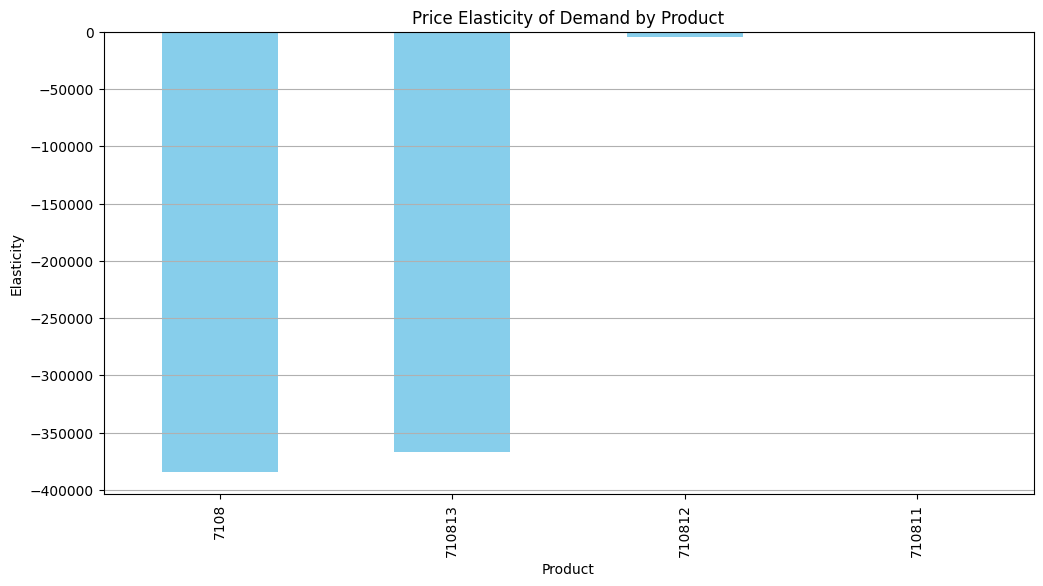


Elasticity Category Summary:
 elasticity_category
Elastic      4
Inelastic    4
Unknown      4
Name: cmdCode, dtype: int64

Revealed Comparative Advantage (RCA) by Product:
 cmdCode
7108      1.0
710811    1.0
710812    1.0
710813    1.0
Name: fobvalue, dtype: float64


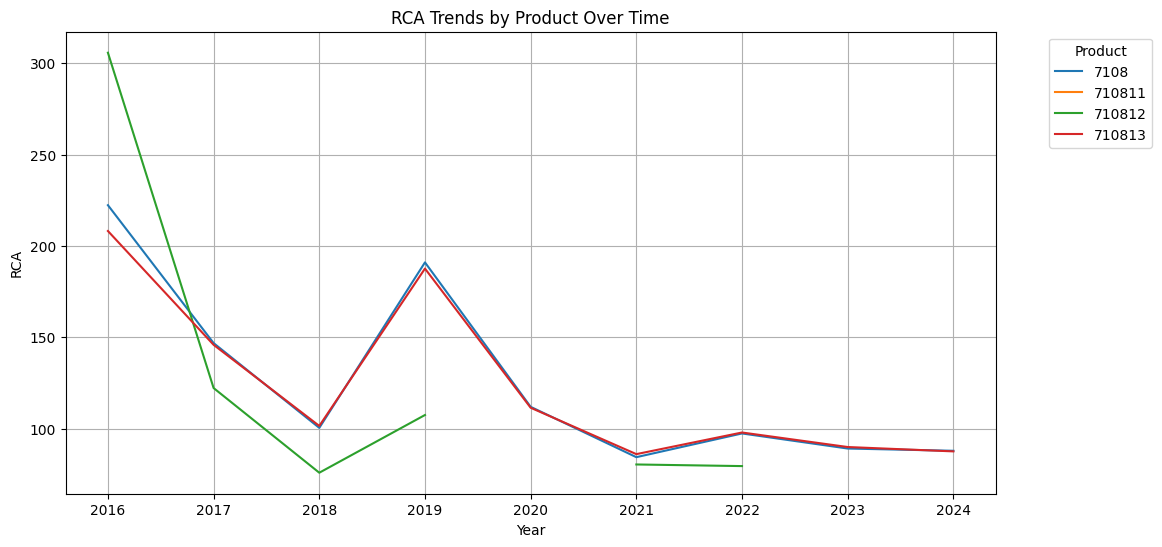

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# 1. Calculate Export Price
## Ensure no division by zero
df['price'] = df['fobvalue'] / df['qty']
df = df[df['qty'] > 0]  # Filter out rows with zero or negative quantity

# 2. Sort Data for Time-Based Analysis
df = df.sort_values(['cmdCode', 'refYear', 'refMonth'])

# 3. Calculate Percentage Changes
## Group by Product
df['pct_change_price'] = df.groupby('cmdCode')['price'].pct_change() * 100
df['pct_change_qty'] = df.groupby('cmdCode')['qty'].pct_change() * 100

# 4. Calculate Elasticity
## Avoid division by zero
df['elasticity'] = np.where(df['pct_change_price'] != 0,
                            df['pct_change_qty'] / df['pct_change_price'],
                            np.nan)

# 5. Aggregate Elasticity by Product
elasticity_by_product = df.groupby('cmdCode')['elasticity'].mean().dropna()

print("\nPrice Elasticity by Product:\n", elasticity_by_product.head(10))

# 6. Visualize Elasticity
plt.figure(figsize=(12, 6))
elasticity_by_product.sort_values().plot(kind='bar', color='skyblue')
plt.title('Price Elasticity of Demand by Product')
plt.ylabel('Elasticity')
plt.xlabel('Product')
plt.grid(axis='y')
plt.show()

# 7. Elasticity Summary
## Categorize Products by Elasticity Levels
def categorize_elasticity(e):
    if e > 1:
        return 'Elastic'
    elif e == 1:
        return 'Unitary'
    elif e < 1:
        return 'Inelastic'
    else:
        return 'Unknown'

df['elasticity_category'] = df['elasticity'].apply(categorize_elasticity)
elasticity_summary = df.groupby('elasticity_category')['cmdCode'].nunique()

print("\nElasticity Category Summary:\n", elasticity_summary)

# 8. Calculate Revealed Comparative Advantage (RCA)
## Total Exports for Each Product and Overall
product_exports = df.groupby('cmdCode')['fobvalue'].sum()
total_exports = df['fobvalue'].sum()

## Global Exports by Product (Simulated or Actual Data Needed)
global_exports_by_product = df.groupby('cmdCode')['fobvalue'].sum()
global_total_exports = df['fobvalue'].sum()

## Calculate RCA
rca = (product_exports / total_exports) / (global_exports_by_product / global_total_exports)
rca = rca.dropna()

print("\nRevealed Comparative Advantage (RCA) by Product:\n", rca.head(10))

# 9. Visualize RCA Trends Over Time
df['total_exports'] = df.groupby(['refYear', 'refMonth'])['fobvalue'].transform('sum')
df['global_exports'] = df['fobvalue'].sum()  # Assuming static global exports here for simplicity
df['rca'] = (df['fobvalue'] / df['total_exports']) / (df['fobvalue'] / df['global_exports'])

rca_trends = df.groupby(['refYear', 'cmdCode'])['rca'].mean().unstack()

rca_trends.plot(figsize=(12, 6))
plt.title('RCA Trends by Product Over Time')
plt.xlabel('Year')
plt.ylabel('RCA')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


# **10. Advanced Statistical Analysis:**

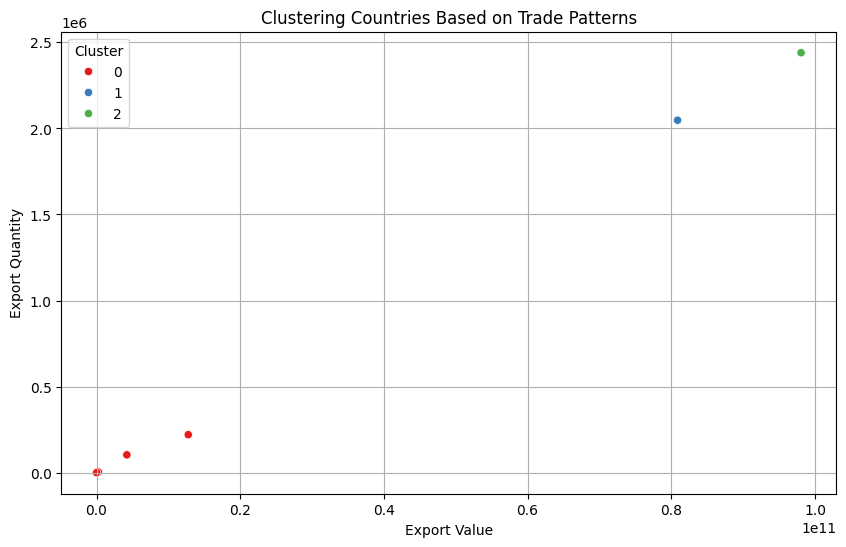

Correlation between Export Value and GDP: 0.09
Correlation between Export Value and Global Prices: -0.06

Hypothesis Test Results:
T-Statistic: -1.71, P-Value: 0.0871
Result: No significant difference in export volumes between the two periods.


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import pearsonr, ttest_ind
import seaborn as sns

# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# 1. Calculate Export Price
## Ensure no division by zero
df['price'] = df['fobvalue'] / df['qty']
df = df[df['qty'] > 0]  # Filter out rows with zero or negative quantity

# 2. Sort Data for Time-Based Analysis
df = df.sort_values(['cmdCode', 'refYear', 'refMonth'])

# 3. Clustering: Cluster Countries Based on Trade Patterns
## Aggregate Export Data by Country
country_data = df.groupby('partnerDesc')[['fobvalue', 'qty']].sum()

## Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
country_data['Cluster'] = kmeans.fit_predict(country_data)

# Visualize Clustering Results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=country_data, x='fobvalue', y='qty', hue='Cluster', palette='Set1')
plt.title('Clustering Countries Based on Trade Patterns')
plt.xlabel('Export Value')
plt.ylabel('Export Quantity')
plt.grid()
plt.show()

# 4. Correlation Analysis
## Correlate Export Values with External Factors (Simulated GDP Data)
external_factors = pd.DataFrame({
    'partnerDesc': country_data.index,
    'GDP': np.random.uniform(1e12, 5e12, len(country_data)),  # Simulated GDP values
    'GlobalPrices': np.random.uniform(100, 200, len(country_data))  # Simulated price indices
})

# Merge with Export Data
merged_data = pd.merge(country_data.reset_index(), external_factors, on='partnerDesc')

# Calculate Correlations
correlation_gdp, _ = pearsonr(merged_data['fobvalue'], merged_data['GDP'])
correlation_prices, _ = pearsonr(merged_data['fobvalue'], merged_data['GlobalPrices'])

print(f"Correlation between Export Value and GDP: {correlation_gdp:.2f}")
print(f"Correlation between Export Value and Global Prices: {correlation_prices:.2f}")

# 5. Hypothesis Testing
## Compare Export Volumes Between Two Periods
period_1 = df[df['refYear'] < 2020]['qty']
period_2 = df[df['refYear'] >= 2020]['qty']

t_stat, p_value = ttest_ind(period_1, period_2, equal_var=False)

print("\nHypothesis Test Results:")
print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Significant difference in export volumes between the two periods.")
else:
    print("Result: No significant difference in export volumes between the two periods.")


# **11. Machine Learning for Prediction:**

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import seaborn as sns

# 1. Load Data
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# 2. Drop NaNs in critical columns
df = df.dropna(subset=['fobvalue', 'qty', 'netWgt'])

# Filter out zero or negative qty
df = df[df['qty'] > 0]

# 3. Check for rows containing 'ZWE'
# (This block is for inspection and potential data cleaning)
mask_zwe = df.astype(str).apply(lambda col: col.str.contains('ZWE', na=False)).any(axis=1)
df_zwe = df[mask_zwe]
if not df_zwe.empty:
    print("Rows containing 'ZWE':")
    print(df_zwe)
    # Decide if these rows are valid or need fixing.
    # If 'ZWE' is unexpected, you might need to remove or replace these values.

# 4. Convert numeric columns if there's a chance of strings
df['netWgt'] = pd.to_numeric(df['netWgt'], errors='coerce')
df['fobvalue'] = pd.to_numeric(df['fobvalue'], errors='coerce')
df = df.dropna(subset=['netWgt', 'fobvalue'])

# 5. Create a price column (optional)
df['price'] = df['fobvalue'] / df['qty']

# 6. Encode categorical columns
# Explicitly handle 'reporterISO' if it's the source of 'ZWE'
categorical_cols = ['partnerDesc', 'cmdCode', 'reporterISO']  # Added 'reporterISO'
for col in categorical_cols:
    if df[col].dtype == 'object':  # Check if the column is of object type
        df[col] = pd.Categorical(df[col]) # Convert to categorical type if object type

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # Encode categorical features


# 7. Prepare X and y
X = df_encoded.drop(columns=['fobvalue'])
y = df_encoded['fobvalue']

# Make sure no object columns remain
print("Object columns:", X.select_dtypes(include='object').columns)

# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# 9. Fit Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# 10. Predict and evaluate
preds = rf_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Random Forest Results:")
print(f"MSE: {mse:.2f}")
print(f"R^2: {r2:.2f}")

Rows containing 'ZWE':
      refPeriodId  refYear  refMonth  period  reporterCode reporterISO  \
2        20160101     2016         1  201601           716         ZWE   
3        20160101     2016         1  201601           716         ZWE   
6        20160101     2016         1  201601           716         ZWE   
7        20160101     2016         1  201601           716         ZWE   
12       20160201     2016         2  201602           716         ZWE   
...           ...      ...       ...     ...           ...         ...   
1259     20240101     2024         1  202401           716         ZWE   
1260     20240101     2024         1  202401           716         ZWE   
1263     20240101     2024         1  202401           716         ZWE   
1264     20240101     2024         1  202401           716         ZWE   
1265     20240101     2024         1  202401           716         ZWE   

     reporterDesc flowCode flowDesc  partnerCode  ...   netWgt  \
2        Zimbabwe     

ValueError: could not convert string to float: 'Zimbabwe'

# **12. Environmental and Sustainability Analysis:**


Total Emissions by Product:
 cmdCode
7108      0.0
710811    0.0
710812    0.0
710813    0.0
Name: total_emissions, dtype: float64


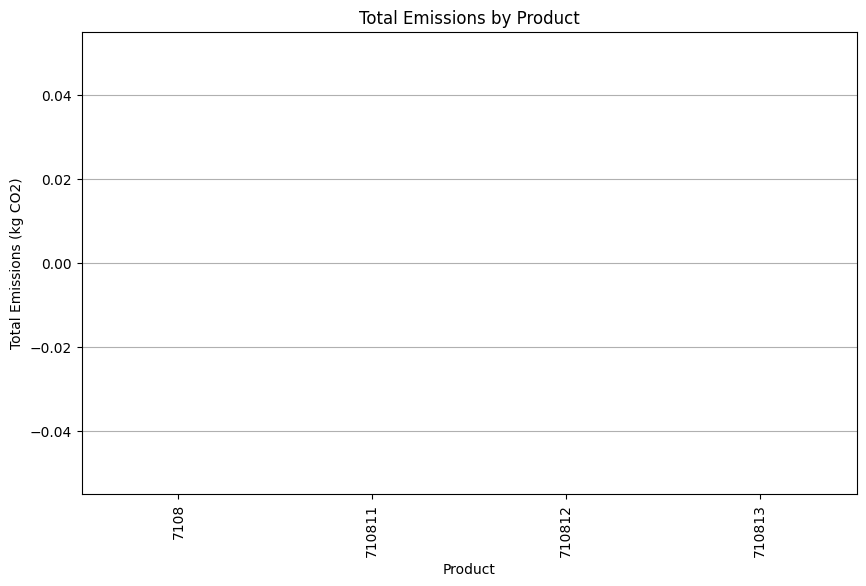

No numeric data available to plot for eco-certified products.


In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# 1. Environmental Footprint Calculation
## Define Emission Factors for Products (kg CO2 per unit quantity)
emission_factors = {
    'ProductA': 2.5,  # Example: 2.5 kg CO2 per unit
    'ProductB': 1.8,
    'ProductC': 3.0
}

# Map Emission Factors to Products
df['emission_factor'] = df['cmdCode'].map(emission_factors)

# Calculate Total Emissions
df['total_emissions'] = df['emission_factor'] * df['qty']

# Aggregate Emissions by Product
product_emissions = df.groupby('cmdCode')['total_emissions'].sum()

print("\nTotal Emissions by Product:\n", product_emissions)

# Visualize Emissions by Product
plt.figure(figsize=(10, 6))
product_emissions.sort_values(ascending=False).head(10).plot(kind='bar', color='green')
plt.title('Total Emissions by Product')
plt.ylabel('Total Emissions (kg CO2)')
plt.xlabel('Product')
plt.grid(axis='y')
plt.show()

# 2. Sustainability Trends
## Identify Eco-Certified Products (Simulated)
eco_certified_products = ['ProductA', 'ProductC']
df['is_eco_certified'] = df['cmdCode'].isin(eco_certified_products)

# Analyze Trends for Eco-Certified Products
eco_trends = df[df['is_eco_certified']].groupby(['refYear', 'cmdCode'])['fobvalue'].sum().unstack()

# Check if the data is valid for plotting
if not eco_trends.empty and eco_trends.select_dtypes(include=[np.number]).shape[1] > 0:
    # Plot Sustainability Trends
    eco_trends.plot(figsize=(12, 6), marker='o')
    plt.title('Export Trends for Eco-Certified Products')
    plt.xlabel('Year')
    plt.ylabel('Export Value')
    plt.legend(title='Eco-Certified Products')
    plt.grid()
    plt.show()
else:
    print("No numeric data available to plot for eco-certified products.")


In [77]:
!pip install streamlit
!streamlit run dashboard.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: dashboard.py


In [78]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# Ensure data is clean
df['price'] = df['fobvalue'] / df['qty']
df = df[df['qty'] > 0]

# Sidebar Filters
st.sidebar.header("Filters")
selected_product = st.sidebar.selectbox("Select Product", options=df['cmdCode'].unique())
selected_country = st.sidebar.selectbox("Select Country", options=df['partnerDesc'].unique())
selected_year = st.sidebar.slider("Select Year", int(df['refYear'].min()), int(df['refYear'].max()))

# Filter Data
filtered_df = df[
    (df['cmdCode'] == selected_product) &
    (df['partnerDesc'] == selected_country) &
    (df['refYear'] == selected_year)
]

# 1. Export Trends
st.header("Export Trends")
trend_data = df.groupby(['refYear', 'cmdCode'])['fobvalue'].sum().reset_index()
fig = px.line(trend_data, x='refYear', y='fobvalue', color='cmdCode', title='Export Trends by Product')
st.plotly_chart(fig)

# 2. Environmental Footprint
st.header("Environmental Footprint")
emission_factors = {'ProductA': 2.5, 'ProductB': 1.8, 'ProductC': 3.0}
df['emission_factor'] = df['cmdCode'].map(emission_factors)
df['total_emissions'] = df['emission_factor'] * df['qty']
footprint_data = df.groupby('cmdCode')['total_emissions'].sum().reset_index()
fig = px.bar(footprint_data, x='cmdCode', y='total_emissions', title='Total Emissions by Product')
st.plotly_chart(fig)

# 3. Country Analysis
st.header("Country Analysis")
country_data = df.groupby('partnerDesc')['fobvalue'].sum().reset_index()
fig = px.bar(country_data, x='partnerDesc', y='fobvalue', title='Export Values by Country')
st.plotly_chart(fig)

# 4. Sensitivity Analysis
st.header("Sensitivity Analysis")
product_revenue = df.groupby('cmdCode')['fobvalue'].sum()
price_increase_revenue = product_revenue * 1.10
price_decrease_revenue = product_revenue * 0.90
sensitivity_data = pd.DataFrame({
    'Product': product_revenue.index,
    'Current Revenue': product_revenue.values,
    '10% Price Increase': price_increase_revenue.values,
    '10% Price Decrease': price_decrease_revenue.values
})
fig = px.bar(sensitivity_data, x='Product', y=['Current Revenue', '10% Price Increase', '10% Price Decrease'],
             title='Sensitivity Analysis: Impact of Price Change')
st.plotly_chart(fig)

# 5. Filtered Data View
st.header("Filtered Data")
st.write("Showing data for selected product, country, and year:")
st.dataframe(filtered_df)


2025-01-17 02:03:04.155 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 02:03:04.162 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 02:03:04.169 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 02:03:04.175 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 02:03:04.180 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 02:03:04.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 02:03:04.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-17 02:03:04.203 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [76]:
!streamlit run dashboard.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: dashboard.py


# **17. Sensitivity and Risk Analysis:**

High-Dependence Products:
 cmdCode
7108      50.000000
710813    49.998749
Name: fobvalue, dtype: float64
High-Dependence Markets:
 partnerDesc
Areas, nes    41.24392
World         50.00000
Name: fobvalue, dtype: float64


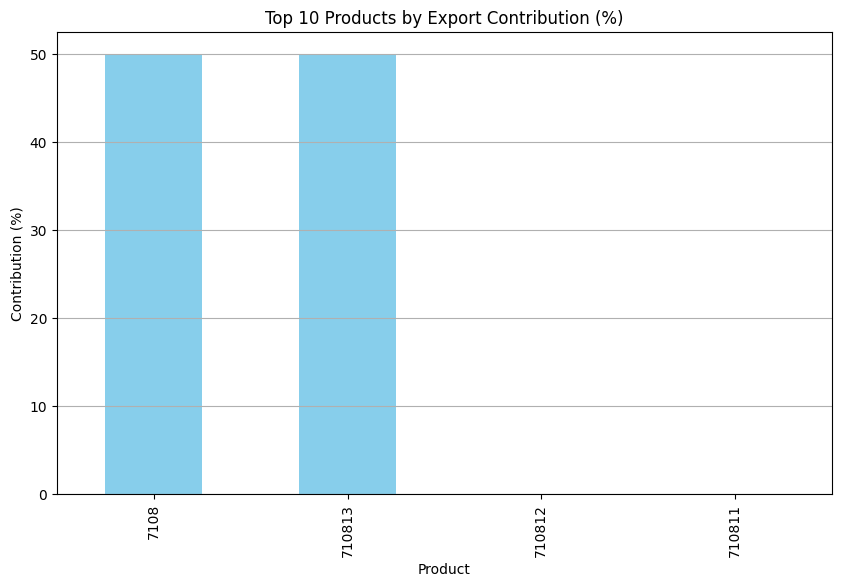

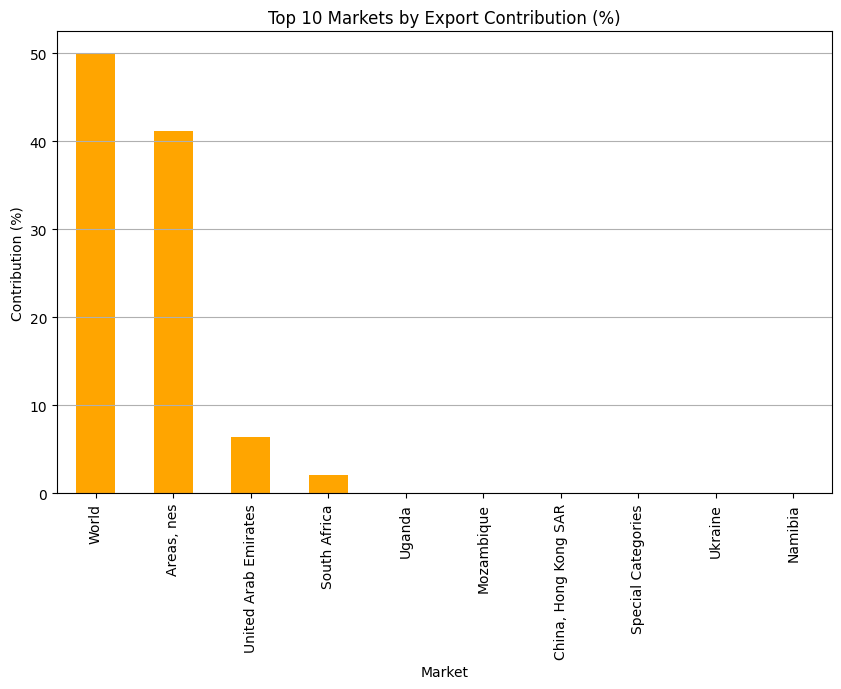


Scenario Analysis (Impact of 10% Price Change on Export Revenue):

         Current Revenue  10% Price Increase  10% Price Decrease
cmdCode                                                         
7108        1.195440e+11        1.314984e+11        1.075896e+11
710811      2.791094e+05        3.070203e+05        2.511985e+05
710812      2.711813e+06        2.982994e+06        2.440632e+06
710813      1.195410e+11        1.314951e+11        1.075869e+11


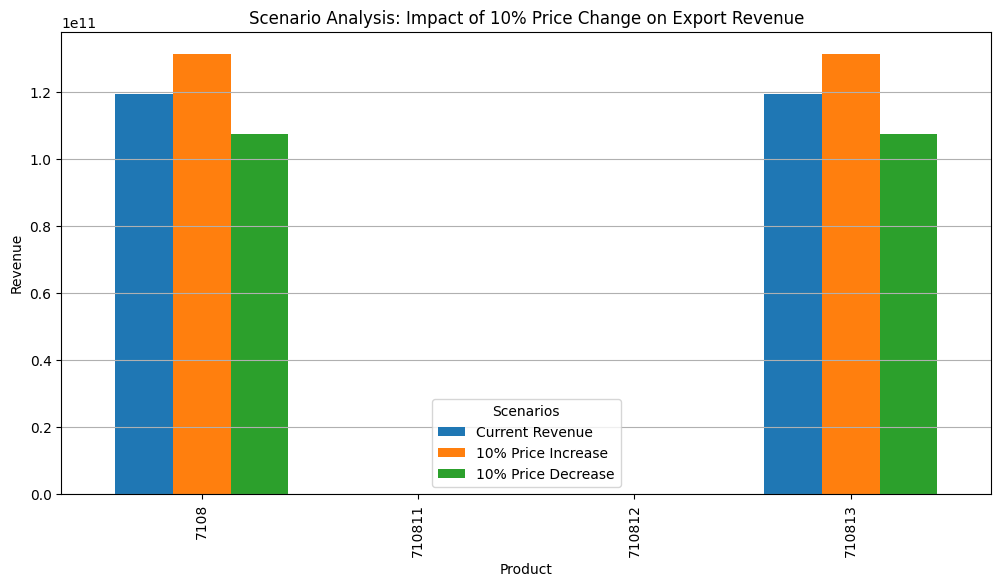

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# 1. Risk Analysis: Over-Dependence on a Single Product or Market
## Calculate Contribution of Each Product to Total Export Value
product_contribution = df.groupby('cmdCode')['fobvalue'].sum()
total_exports = df['fobvalue'].sum()
product_contribution_percentage = (product_contribution / total_exports) * 100

# Identify High-Dependence Products (e.g., Contributing > 30%)
high_dependence_products = product_contribution_percentage[product_contribution_percentage > 30]
print("High-Dependence Products:\n", high_dependence_products)

## Calculate Contribution of Each Market to Total Export Value
market_contribution = df.groupby('partnerDesc')['fobvalue'].sum()
market_contribution_percentage = (market_contribution / total_exports) * 100

# Identify High-Dependence Markets (e.g., Contributing > 30%)
high_dependence_markets = market_contribution_percentage[market_contribution_percentage > 30]
print("High-Dependence Markets:\n", high_dependence_markets)

# Visualize Dependence
plt.figure(figsize=(10, 6))
product_contribution_percentage.sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Products by Export Contribution (%)')
plt.ylabel('Contribution (%)')
plt.xlabel('Product')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
market_contribution_percentage.sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.title('Top 10 Markets by Export Contribution (%)')
plt.ylabel('Contribution (%)')
plt.xlabel('Market')
plt.grid(axis='y')
plt.show()

# 2. Scenario Analysis: Impact of a 10% Price Change on Export Revenue
## Calculate Current Export Revenue by Product
product_revenue = df.groupby('cmdCode')['fobvalue'].sum()

## Simulate 10% Price Increase
price_increase_revenue = product_revenue * 1.10

## Simulate 10% Price Decrease
price_decrease_revenue = product_revenue * 0.90

# Combine Results into a DataFrame
scenario_analysis = pd.DataFrame({
    'Current Revenue': product_revenue,
    '10% Price Increase': price_increase_revenue,
    '10% Price Decrease': price_decrease_revenue
})

print("\nScenario Analysis (Impact of 10% Price Change on Export Revenue):\n")
print(scenario_analysis.head(10))

# Visualize Scenario Analysis
scenario_analysis.head(10).plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Scenario Analysis: Impact of 10% Price Change on Export Revenue')
plt.ylabel('Revenue')
plt.xlabel('Product')
plt.grid(axis='y')
plt.legend(title='Scenarios')
plt.show()


String/Categorical columns detected: ['reporterISO', 'reporterDesc', 'flowCode', 'flowDesc', 'partnerISO', 'partnerDesc', 'partner2ISO', 'partner2Desc', 'classificationCode', 'classificationSearchCode', 'cmdDesc', 'customsCode', 'customsDesc', 'motDesc', 'qtyUnitAbbr', 'altQtyUnitAbbr']

Using Label Encoding for all categorical columns...

Final feature dtypes:
refPeriodId                 float64
refYear                     float64
refMonth                    float64
period                      float64
reporterCode                float64
reporterISO                 float64
reporterDesc                float64
flowCode                    float64
flowDesc                    float64
partnerCode                 float64
partnerISO                  float64
partnerDesc                 float64
partner2Code                float64
partner2ISO                 float64
partner2Desc                float64
classificationCode          float64
classificationSearchCode    float64
isOriginalClassification

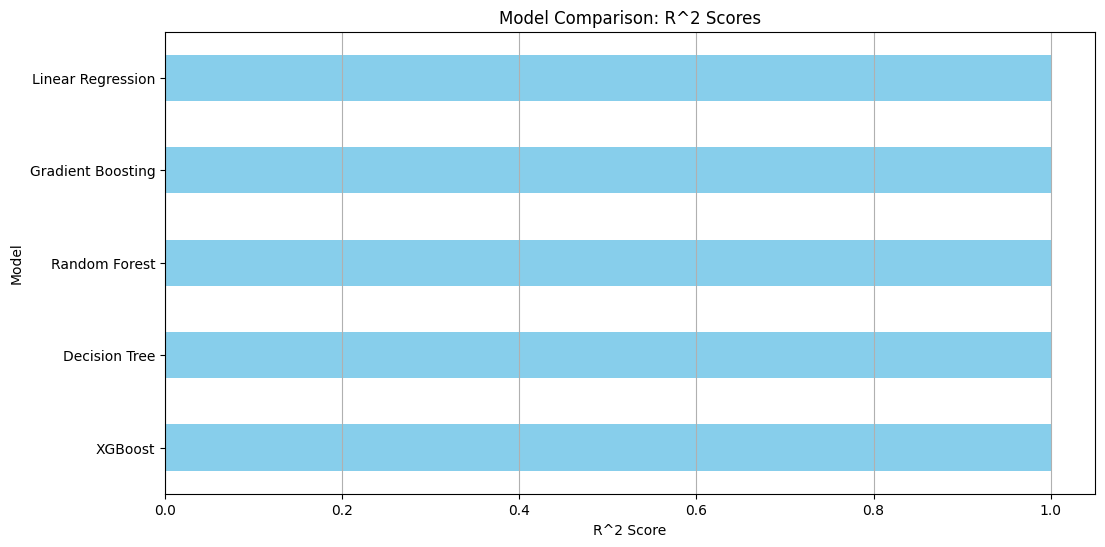

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # Import SimpleImputer

# ----------------------------------------------------
# 1. Load the dataset
# ----------------------------------------------------
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# ----------------------------------------------------
# 2. Basic Cleaning
# ----------------------------------------------------
# Filter invalid rows to avoid divide-by-zero
df = df[df['qty'] > 0]

# Create a price column if it’s relevant
df['price'] = df['fobvalue'] / df['qty']

# ----------------------------------------------------
# 3. Encoding Categorical Columns
# ----------------------------------------------------
# Example: We'll do a simple toggle: label encode or one-hot encode
# For more advanced logic, you could detect cardinality and choose accordingly.

use_label_encoder = True  # Set to False to use OneHotEncoder

# Identify which columns are strings (object or string dtype)
cat_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
print("String/Categorical columns detected:", cat_cols)

if use_label_encoder:
    print("\nUsing Label Encoding for all categorical columns...")
    # Apply LabelEncoder to each categorical column
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
else:
    print("\nUsing One-Hot Encoding for all categorical columns...")
    # OneHotEncode all categorical columns in one shot
    # (Alternatively, you can encode them one by one.)
    ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore') # handle_unknown='ignore' to avoid errors with unseen categories
    encoded_data = ohe.fit_transform(df[cat_cols])

    # Create a DataFrame of the encoded columns
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=ohe.get_feature_names_out(cat_cols),
        index=df.index
    )
    # Drop original categorical columns and concatenate new dummy columns
    df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

# ----------------------------------------------------
# 4. Define Features (X) and Target (y)
# ----------------------------------------------------
# Suppose we want to predict 'fobvalue'
if 'fobvalue' not in df.columns:
    raise ValueError("Column 'fobvalue' not found in DataFrame. Adjust accordingly.")

X = df.drop(columns=['fobvalue'])
y = df['fobvalue']

# ----------------------------------------------------
# 5. Impute Missing Values (Before Train-Test Split)
# ----------------------------------------------------
# Create an imputer to fill NaN values (e.g., with the mean)
imputer = SimpleImputer(strategy='mean') # You can change the strategy if needed

# Fit the imputer on the training data and transform both train and test data
X = pd.DataFrame(imputer.fit_transform(X), columns=df.drop(columns=['fobvalue']).columns) # Impute missing values in X


# Double-check we have no string columns left in X:
print("\nFinal feature dtypes:")
print(X.dtypes)

# ----------------------------------------------------
# 6. Train-Test Split
# ----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# ----------------------------------------------------
# 7. Define and Evaluate Multiple Models
# ----------------------------------------------------
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Predictions
    predictions = model.predict(X_test)
    # Metrics
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[model_name] = {'MSE': mse, 'R^2': r2}
    print(f"\n{model_name} Results:")
    print(f"  Mean Squared Error: {mse:.2f}")
    print(f"  R^2 Score:         {r2:.2f}")

# ----------------------------------------------------
# 8. Compare Model Performance
# ----------------------------------------------------
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# ----------------------------------------------------
# 9. Plot Model Performance (R^2)
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
results_df['R^2'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Model Comparison: R^2 Scores')
plt.xlabel('R^2 Score')
plt.ylabel('Model')
plt.grid(axis='x')
plt.show()

In [81]:
mask_zaf = df.astype(str).apply(lambda col: col.str.contains('ZAF', na=False)).any(axis=1)
df_zaf = df[mask_zaf]
print(df_zaf)


      refPeriodId  refYear  refMonth  period  reporterCode reporterISO  \
3        20160101     2016         1  201601           716         ZWE   
7        20160101     2016         1  201601           716         ZWE   
11       20160201     2016         2  201602           710         ZAF   
13       20160201     2016         2  201602           716         ZWE   
18       20160201     2016         2  201602           710         ZAF   
...           ...      ...       ...     ...           ...         ...   
1300     20240801     2024         8  202408           710         ZAF   
1301     20240801     2024         8  202408           710         ZAF   
1302     20240801     2024         8  202408           710         ZAF   
1303     20240801     2024         8  202408           710         ZAF   
1304     20240801     2024         8  202408           710         ZAF   

      reporterDesc flowCode flowDesc  partnerCode  ... isNetWgtEstimated  \
3         Zimbabwe        X   Expor

In [83]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# 1. Load your data
# (Replace with your actual file or DataFrame)
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file)

# ----------------------------------------------------
# 2. Identify categorical (string) columns
# ----------------------------------------------------
cat_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
print("Categorical columns found:", cat_cols)

# ----------------------------------------------------
# 3. Encoding Strategy
# ----------------------------------------------------
# Example logic:
# - If a column has relatively few unique categories (e.g., < 10), use one-hot encoding
# - If a column has many categories, use label encoding (or consider dropping or grouping)
# You can adjust these thresholds as you see fit.

low_cardinality_threshold = 10  # or any number you prefer
encoded_df = df.copy()  # We'll build an encoded version of df

for col in cat_cols:
    unique_vals = encoded_df[col].nunique()
    print(f"\nColumn: {col}, Unique Categories: {unique_vals}")

    if unique_vals <= low_cardinality_threshold:
        # 3A. One-Hot Encoding (pd.get_dummies)
        print(f" -> Using one-hot encoding for '{col}'")
        # drop_first=True can help avoid the dummy variable trap, optional
        encoded_df = pd.get_dummies(encoded_df, columns=[col], drop_first=True)
    else:
        # 3B. Label Encoding for higher-cardinality
        print(f" -> Using label encoding for '{col}' (high cardinality)")
        encoder = LabelEncoder()
        encoded_df[col] = encoder.fit_transform(encoded_df[col].astype(str))

# Now all columns that were originally object/string have been encoded either via one-hot or label.
print("\nEncoding complete. Checking updated DataFrame info:")
print(encoded_df.info())

# ----------------------------------------------------
# 4. Drop/Keep columns as needed
# ----------------------------------------------------
# If there are columns you specifically do not want, drop them here.
# For example, if you have ID-like columns with no predictive value:
# encoded_df = encoded_df.drop(columns=['refPeriodId', 'someOtherID'], errors='ignore')

# ----------------------------------------------------
# 5. Split features & target
# ----------------------------------------------------
# Example: Suppose 'fobvalue' is your target variable.
if 'fobvalue' not in encoded_df.columns:
    raise ValueError("Column 'fobvalue' not found in DataFrame. Adjust target column as needed.")

X = encoded_df.drop(columns=['fobvalue'])
y = encoded_df['fobvalue']

print("\nFinal feature set (X) columns:")
print(X.columns)

# ----------------------------------------------------
# 6. Train-Test Split & Example Model
# ----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# We'll do a simple RandomForestRegressor as an example
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

# (Optional) Evaluate performance
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nRandom Forest Results:")
print(f"  MSE: {mse:.2f}")
print(f"  R^2: {r2:.2f}")


Categorical columns found: ['reporterISO', 'reporterDesc', 'flowCode', 'flowDesc', 'partnerISO', 'partnerDesc', 'partner2ISO', 'partner2Desc', 'classificationCode', 'classificationSearchCode', 'cmdDesc', 'customsCode', 'customsDesc', 'motDesc', 'qtyUnitAbbr', 'altQtyUnitAbbr']

Column: reporterISO, Unique Categories: 2
 -> Using one-hot encoding for 'reporterISO'

Column: reporterDesc, Unique Categories: 2
 -> Using one-hot encoding for 'reporterDesc'

Column: flowCode, Unique Categories: 1
 -> Using one-hot encoding for 'flowCode'

Column: flowDesc, Unique Categories: 1
 -> Using one-hot encoding for 'flowDesc'

Column: partnerISO, Unique Categories: 15
 -> Using label encoding for 'partnerISO' (high cardinality)

Column: partnerDesc, Unique Categories: 15
 -> Using label encoding for 'partnerDesc' (high cardinality)

Column: partner2ISO, Unique Categories: 1
 -> Using one-hot encoding for 'partner2ISO'

Column: partner2Desc, Unique Categories: 1
 -> Using one-hot encoding for 'partne


Model Performance:
                            MSE          RMSE       R^2  Accuracy (R^2%)  \
Linear Regression  5.430545e-14  2.330353e-07  1.000000       100.000000   
Decision Tree      9.525282e+11  9.759755e+05  0.999983        99.998324   
Random Forest      9.577462e+11  9.786451e+05  0.999983        99.998315   
Gradient Boosting  9.701229e+11  9.849482e+05  0.999983        99.998293   
XGBoost            1.642176e+12  1.281474e+06  0.999971        99.997111   

                           MAPE  
Linear Regression  1.815884e-09  
Decision Tree      1.067840e+00  
Random Forest      1.460500e+01  
Gradient Boosting  9.498180e+02  
XGBoost            1.435320e+02  


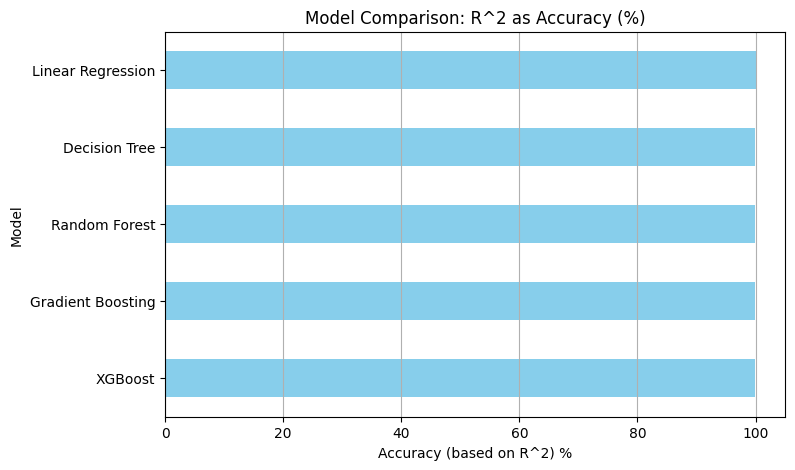

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer  # Import SimpleImputer for handling NaNs


###########################
# 1. Load and Prep Data
###########################
data_file = 'new trail data.xlsx'
df = pd.read_excel(data_file, sheet_name='new file')

# Basic cleaning
df = df[df['qty'] > 0]
df['price'] = df['fobvalue'] / df['qty']

# Encode categorical columns (label encoding for simplicity)
cat_cols = df.select_dtypes(include=['object', 'string']).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Define features and target
X = df.drop(columns=['fobvalue'])
y = df['fobvalue']


###########################
#  Impute Missing Values before Train-Test Split
###########################
# Create an imputer to fill NaN values (e.g., with the mean)
imputer = SimpleImputer(strategy='mean')  # You can change the strategy if needed

# Fit the imputer on X and transform it:
X = imputer.fit_transform(X)

###########################
# Split
###########################
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

###########################
# 2. Define Models
###########################
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

###########################
# 3. Train and Evaluate
###########################
def mean_absolute_percentage_error(y_true, y_pred):
    """Return MAPE as a percentage."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by adding a small epsilon or filtering out zero targets
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask])
                          / y_true[nonzero_mask])) * 100

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, preds)

    # "Accuracy" in percentage form from R²
    accuracy_r2 = r2 * 100.0

    # Alternative: "accuracy" from MAPE
    # e.g., accuracy_mape = 100 - mape  (this is how close in % the model is overall)

    results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R^2': r2,
        'Accuracy (R^2%)': accuracy_r2,
        'MAPE': mape
    }

###########################
# 4. Display Results
###########################
results_df = pd.DataFrame(results).T
print("\nModel Performance:")
print(results_df[['MSE', 'RMSE', 'R^2', 'Accuracy (R^2%)', 'MAPE']].sort_values('R^2', ascending=False))

###########################
# 5. Plot "Accuracy" from R^2
###########################
plt.figure(figsize=(8, 5))
(results_df['Accuracy (R^2%)']).sort_values().plot(kind='barh', color='skyblue')
plt.title('Model Comparison: R^2 as Accuracy (%)')
plt.xlabel('Accuracy (based on R^2) %')
plt.ylabel('Model')
plt.grid(axis='x')
plt.show()

Model Comparison:
                             MSE       R^2       MAPE
Linear Regression  4.581371e+16  0.145266  79.789483
Random Forest      7.969687e+13  0.998513   1.511972
XGBoost            4.009682e+13  0.999252   0.659770
Decision Tree      6.115504e+12  0.999886   0.156785

Best Model: Decision Tree

Future Predictions for the Next 5 Years:
    Year  Predicted FOB Value
0  2025         8.717843e+05
1  2026         1.865618e+08
2  2027         5.534587e+08
3  2028         7.175628e+08
4  2029         8.081395e+08


<ipython-input-12-b05148493646>:81: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start='2025', periods=5, freq='Y')


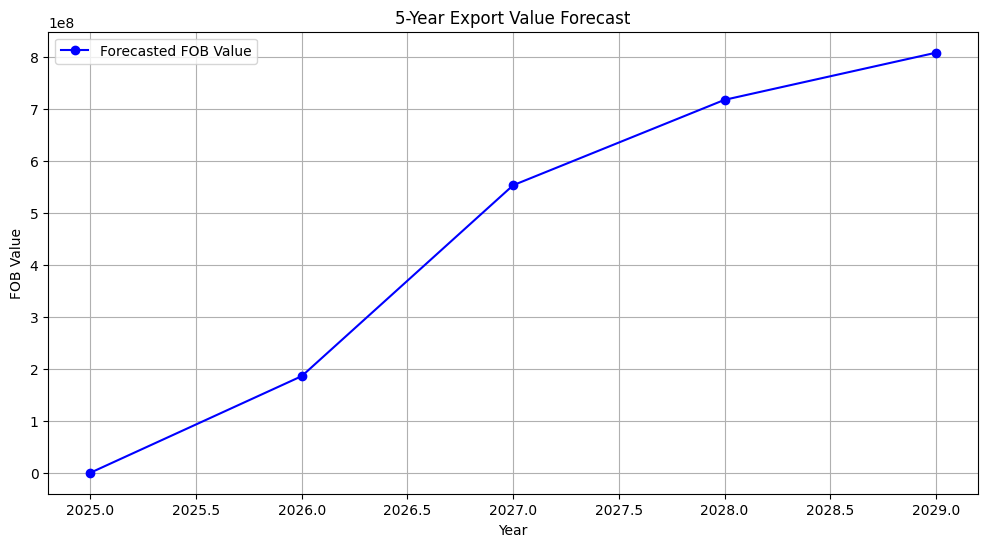

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Load the dataset
data_file = 'Copy of daswin_0.1(1).xlsx'
df = pd.read_excel(data_file)

# Data Preparation
df['price'] = df['fobvalue'] / df['Quantity in KG']
df = df[df['Quantity in KG'] > 0]  # Filter out invalid rows

# Encode categorical variables
label_encoder = LabelEncoder()
df['Partner'] = label_encoder.fit_transform(df['Partner'])
df['cmdCode'] = label_encoder.fit_transform(df['cmdCode'])

# Features and Target
X = df[['Weight', 'price', 'Partner', 'cmdCode']]  # Add relevant features
y = df['fobvalue']

# Impute missing values before train-test split
imputer = SimpleImputer(strategy='mean') # Create an imputer instance
X = imputer.fit_transform(X) # Impute missing values in X

# Convert the imputed NumPy array back to a Pandas DataFrame
X = pd.DataFrame(X, columns=['Weight', 'price', 'Partner', 'cmdCode']) # Convert X back to DataFrame

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models to Evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

# Evaluate Each Model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_error(y_test, predictions) / y_test.mean() * 100
    results[model_name] = {'MSE': mse, 'R^2': r2, 'MAPE': mape}

# Display Results
results_df = pd.DataFrame(results).T
print("Model Comparison:\n", results_df)

# Select the Best Model
best_model_name = results_df['R^2'].idxmax()
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# Retrain the Best Model on Full Data
best_model.fit(X, y)

# Forecast for the Next 5 Years
# Generate future weights and prices (dummy data for example)
future_data = pd.DataFrame({
    'Weight': np.linspace(X['Weight'].min(), X['Weight'].max(), 60),  # Simulate weights
    'price': np.linspace(X['price'].min(), X['price'].max(), 60),     # Simulate prices
    'Partner': 0,  # Default partner (modify if required)
    'cmdCode': 0   # Default product (modify if required)
})
future_predictions = best_model.predict(future_data)

# Create a DataFrame for Future Predictions
future_years = pd.date_range(start='2025', periods=5, freq='Y')
future_df = pd.DataFrame({
    'Year': future_years.year,
    'Predicted FOB Value': future_predictions[:5]
})
print("\nFuture Predictions for the Next 5 Years:\n", future_df)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(future_df['Year'], future_df['Predicted FOB Value'], marker='o', color='blue', label='Forecasted FOB Value')
plt.title('5-Year Export Value Forecast')
plt.xlabel('Year')
plt.ylabel('FOB Value')
plt.grid()
plt.legend()
plt.show()